# Aspect/Modifier Classification Analysis



### Overview 






## rework overview section

    The target for this project is an established e-commerce business with a large amount of review data, such as Amazon.com or other online retailers. The goal of this project is to take advantage of technology and models provided by Spacy combined with a pretrained sentiment intensity classifier provided by the NLTK toolkit in order to perform more fine grained sentiment analysis at scale in an efficient manner. This project takes advantange of the parsing and part of speech tagging capabilites of Spacy's pipeline in order to extract aspect/sentiment pairs. After the aspects are identified, they can be grouped using simple unsupervised clustering techniques, in this case k-means clustering for model speed and simplicity. The buisness can use the finished product to quickly transform a large amount of informal review data (text data from reviews that may ramble for pages) and transform it into simple visuals in order to key into a small number of categories to focus resources into improving based on newly transformed informal customer feedback. 


 
Data Exploration Notebook
Author: Dylan Dey

This project it available on github here: Github Project Link

The Author can reached by email: ddey2985@gmail.com

## Buisness Problem
   
 
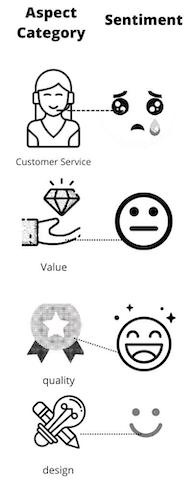
           
    Sentiment analysis involves computationally identifying and categorizing the sentiment expressed by an author in a body of text. It has a wide range of applications in industry from stock speculation using sentiment expressed in news and blogs, to identifying customer satisfaction from their reviews and social media posts. 
    Today, most e-commerce website designs include a section where their customers can post reviews for products or services. Customers are free to write how they feel about fine grained aspects of a product at length. From a business perspective, very valuable information can be extracted from this section, such as customers' opinion on a product, understanding of a product, etc..
     On Amazon.com the rating can be between 1 and 5 where 1 is the worst and 5 is the best. A customer can leave as lengthy of a review as they wish about a product to explain why a given rating was posted.  For example, a customer may give a product a low rating because they didn't like someone they spoke to in customer service but liked everything else about the product.  In typical sentiment analysis, these kinds of nuances would be missed since it could only be determined  if the overall body of the review contained positive, neutral, or negative sentiment. Valuable information would be left on the table. 
     There is potentially a disconnect from the amazon review ratings, and the overall sentiment of the body text explaining the review, especially if you begin to break down the text into smaller aspects. Thus, Aspect Based Sentiment Analysis (ABSA) was chosen to see if a deeper understanding of each product can be gained by breaking down each review into aspect categories to be paired with predicted sentiment, which will then be compared with the overall rating (1-5). 
     It is often difficult to efficiently get useful data from a large collection of text data. A lot of e-commerce websites have thousands of reviews and more incoming all of the time. Thousands of reviews with hundreds of words of mostly unhelpful information seems fairly unmanageable to most companies. While the reviews are rather informal, if they are carefully broken down there is information worth saving before generalizing again for efficiency. Aspect Based Sentiment Analysis can transform a messy collection of thousands of informal reviews into a neat and manageable collection of a few aspect categories, in this case 4 different categories using the out of box  Aspect/Opinion/Sentiment Triplet Extractor. Each category will have an associated degree of sentiment related to it, and therefore graphics can easily be prepared and presented to digest more precisely what it is that customers do and do not like about a product in a quickly digestible format in real time. By breaking it down into these categories, say for example Product Design, Value, Quality, and Customer Support, the mass of text data has now been transformed into a numerical representation of sentiment towards broad categories of a product that can be directly improved upon by the company. If a product scores very high sentiment for value and design but lower scores for customer support, then a company knows it doesnt need to invest more money into improving the product and actually needs to focus on improving how its forward facing employees interact with customers. 

## The Data

Helpful links: 

[ReadMe file for Amazon Product Reviews](https://s3.amazonaws.com/amazon-reviews-pds/readme.html)
[MetaData](https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt)


The Amazon Customer Reviews (Product Reviews) contains over 130+ million customer reviews available to researchers in TSV files in the amazon-reviews-pds S3 bucket in AWS US East Region, as per the provided readme file. The reviews were collected from 1995 to 2015. See the provided link for associated metadata. This project focuses on the dataset given by pulling “https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Electronics_v1_00.tsv.gz” from the S3 bucket.

Product_id ["B0001FTVEK"](https://www.amazon.com/Sennheiser-RS120-Wireless-Headphones-Charging/dp/B0001FTVEK) was chosen to showcase the triplet extractor as it had a large amount of verified reviews and a pair of headphones seemed like a reasonable choice for aspect based sentiment analysis.

##### Clean Data
Text data trends towards exponential growth with increasing dataset size. Therefore, text cleaning and preprocessing was a major considersation of this project. Please refer to my [Text Preprocessing Toolset](https://github.com/ddey117/preprocess_ddey117) that I created to use for this and other projects that involve text data preprocessing. 


#### Unlabeled Data Created Through Unsupervised Learning

This project showcases an out of box product for extracting opinon/aspect/sentiment triplets from a large amount of messy text data and converting it into a neat set of categories for analysis. To do this, however, it takes advantage of some simple clustering techniques from the sklearn cluster library. For this project, kmeans clustering was chosen for speed and simplicity. Error analysis will be discussed later in more detail in regards to how the model performs with clustering the reviews appropriately into categories and what issues it may run into when parsing internet language. Error analysis for the [SentimentIntensityClassifier](https://www.nltk.org/howto/sentiment.html) offered by the Natural Language ToolKit (NLTK library) will be tested against this 'newly' generated data from my unsupervised learning will be performed by comparing to a seperate set of hand labeled aspect/modifier pairs by humans in an expiremental setting. 

##### experimental setup
 Using the following [Turk_Form_HTML](Turk_Instructions.html) I crowdsourced some labels from humans using Amazon Mechanical Turk to compare to my model using the SentimentIntensityAnalyzer for each aspect/modifier pair extracted from the Amazon reviews. Amazon Mechanical Turk works by quickly dispersing large amounts of data to a large number of people in order to complete simple tasks for a reward. This experiment was set up to reward a penny for each aspect/modifier pair labeled for sentiment from very negative to very positive with an option for NA from a drop down menu (see html above for reference). In total, 269 workers labeled 3094 aspect/modifier pairs for sentiment intensity. No qualifications or screening was put in place before the workers were chosen, but I did review sections of the data and accept or reject what seemed reasonable. An additional 860 aspect/modifier pairs were hand labeled by a family member who only knew that the labels were extracted from amazon reviews about headphones and followed a similar template as the turk HTML. 


All labels were generated using my triplet extractor on the dataset describing Product_id ["B0001FTVEK"](https://www.amazon.com/Sennheiser-RS120-Wireless-Headphones-Charging/dp/B0001FTVEK) and randomized for different aspect/modifier pairs before sending out to humans for rating for sentiment. 


In [1]:
#import necessary libraries

import pandas as pd
import numpy as np
import dataframe_image as dfi
import string
import re
from matplotlib import pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
# from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer 
# from wordcloud import WordCloud, STOPWORDS
import re,string
import unidecode
import html

import preprocess_ddey117 as pp


import requests
import os
import csv
import urllib.request
import gzip
import sys
import spacy
import json
# import boto3
# from boto.s3.connection import S3Connection

from collections import defaultdict
from sklearn import cluster
import seaborn as sns

import nltk
# nltk.download('vader_lexicon')

import spacy
nlp = spacy.load("en_core_web_lg")

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# from nltk.collocations import *
# bigram_measures = nltk.collocations.BigramAssocMeasures()
# trigram_measures = nltk.collocations.TrigramAssocMeasures()
# fourgram_measures = nltk.collocations.QuadgramAssocMeasures()

/Users/dylandey/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/dylandey/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/dylandey/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/dylandey/anaconda3/en

A large collection of amazon reviews that fall under the "electronics" category. For this project, product_id ["B0001FTVEK"](https://www.amazon.com/Sennheiser-RS120-Wireless-Headphones-Charging/dp/B0001FTVEK) was chosen as it had a large amount of verified reviews and a pair of headphones seemed like a reasonable choice for aspect based sentiment analysis. 

In [2]:
# df = pd.read_csv('data/df_electronics.tsv', sep='\t')
# df.groupby('product_id').count().sort_values(by='star_rating').tail(20)

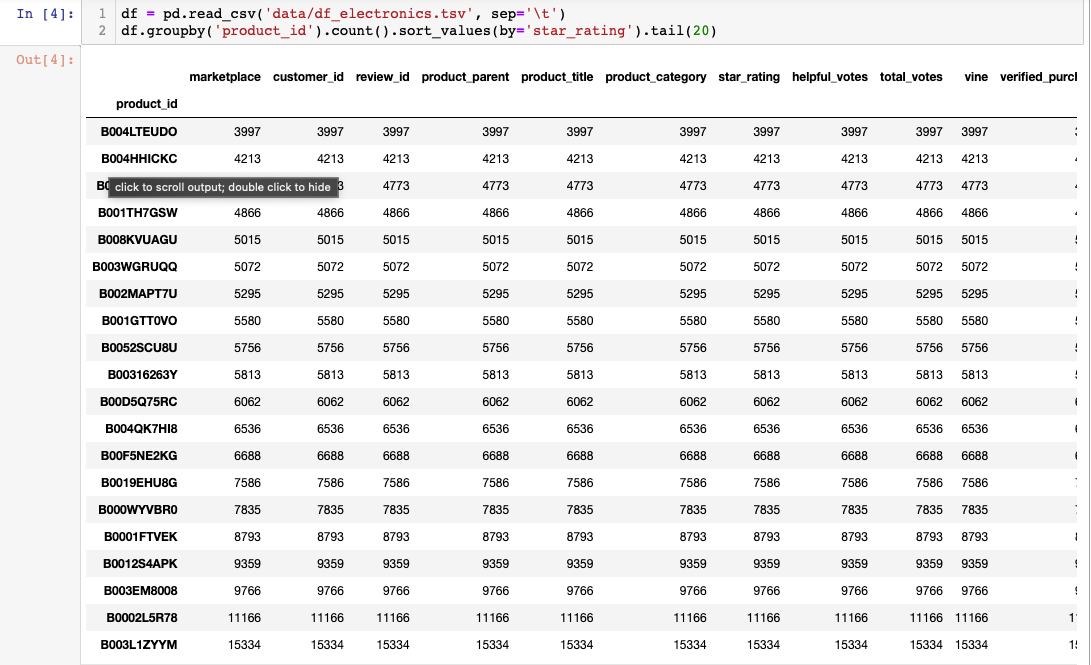

In [3]:
#creating dataframe with only chosen product information

# df2 = df.loc[df['product_id'] == 'B0001FTVEK'].copy()
# df2.reset_index(drop=True, inplace=True)
# df_not_2 = df.loc[df['product_id'] != 'B0001FTVEK'].copy()
# df_not_2.reset_index(drop=True, inplace=True)

In [4]:
#testing other dataframes not shown in this notebook



# df_hp1 = df.loc[df['product_id'] == 'B003EM8008'].copy()
# df_hp1.reset_index(drop=True, inplace=True)
# df_hp2 = df.loc[df['product_id'] == 'B0001FTVEK'].copy()
# df_hp2.reset_index(drop=True, inplace=True)
# df_hp3 = df.loc[df['product_id'] == 'B004RKQM8I'].copy()
# df_hp3.reset_index(drop=True, inplace=True)
# df_hp4 = df.loc[df['product_id'] == 'B0038W0K2K'].copy()
# df_hp4.reset_index(drop=True, inplace=True)

# df_sb1 = df.loc[df['product_id'] == 'B00D5Q75RC'].copy()
# df_sb1.reset_index(drop=True, inplace=True)
# df_sb2 = df.loc[df['product_id'] == 'B00F5NE2KG'].copy()
# df_sb2.reset_index(drop=True, inplace=True)

# df_mp1 = df.loc[df['product_id'] == 'B00020S7XK'].copy()
# df_mp1.reset_index(drop=True, inplace=True)
# df_mp2 = df.loc[df['product_id'] == 'B002MAPT7U'].copy()
# df_mp2.reset_index(drop=True, inplace=True)

In [5]:
# #dropping uneccessary columns 

# columns_td = ['marketplace', 'customer_id',  'product_id',
#               'product_parent', 'product_title', 'product_category', 
#               'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
#               'review_headline', 'review_date']

In [6]:
# df2.drop(columns=columns_td, inplace=True)

In [7]:
#saving dataframe with chosen product for quick loading time

# df2.to_csv('data/df_electronics_example.csv', index=False)

,review_id,star_rating,review_body
0,R17U6AU06HR16Q,5,Great product.
1,R31Y01GPXH7P64,4,work great sounds amazing
2,RG40FO7CNWOG7,5,Works tremendously well.
3,R2CI6TXIGZR6RU,5,THEY WORK GREAT
4,R37KF8VRBUZNQD,5,Works fine




star rating value counts


5    4715
4    1924
1     829
3     724
2     601
Name: star_rating, dtype: int64

<AxesSubplot:>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8793 entries, 0 to 8792
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    8793 non-null   object
 1   star_rating  8793 non-null   int64 
 2   review_body  8793 non-null   object
dtypes: int64(1), object(2)
memory usage: 206.2+ KB


distribution of star rating


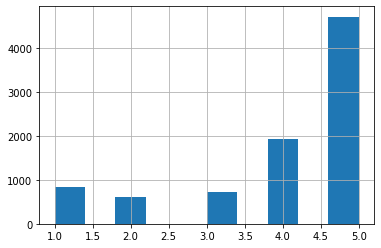

In [6]:
#display important information about dataset
#Almost 9000 reviews, mostly 4 or 5 stars.  

df = pd.read_csv("data/df_electronics_example.csv")
display(df.head())
print("\n")
print('star rating value counts')
display(df.star_rating.value_counts())
display(df.star_rating.hist())
df.info()
print("\n")
print("distribution of star rating")

In [7]:
#I wrote a library for taking care of many common tasks for data language processing.
#However, since this project must load spaCy for parsing the aspect/opinion pairs
#Some of the major processing will be handled by spaCy

#simple processing such as removing emails, html tags, urls
#accented characters and counting all words in the dataset
#are handled with my own toolset

def master_preprocess(df):
    df['wordcounts'] = df['review_body'].apply(lambda x: pp.get_wordcounts(x))
    df['review_body'] = df['review_body'].apply(lambda x: pp.remove_emails(x))
    df['review_body'] = df['review_body'].apply(lambda x: pp.remove_urls(x))
    df['review_body'] = df['review_body'].apply(lambda x: pp.remove_html_tags(x))
    df['review_body'] = df['review_body'].apply(lambda x: pp.remove_accented_chars(x))
    return df

In [8]:
df = master_preprocess(df)

#Looking at the statistics for wordcounts below
#The median length for a amazon review
#for this particular set of headphones is about 50 words
#ranging from 1 to 1565 words for each review
#Thus showing the wide range of informal data that is 
#allowed in the review body and how unmanageable it can
#become
#With this dataset the total amount of words 
#has already reached over half of a million words


display(df.describe())
df.wordcounts.sum()

## Explaining The Parser

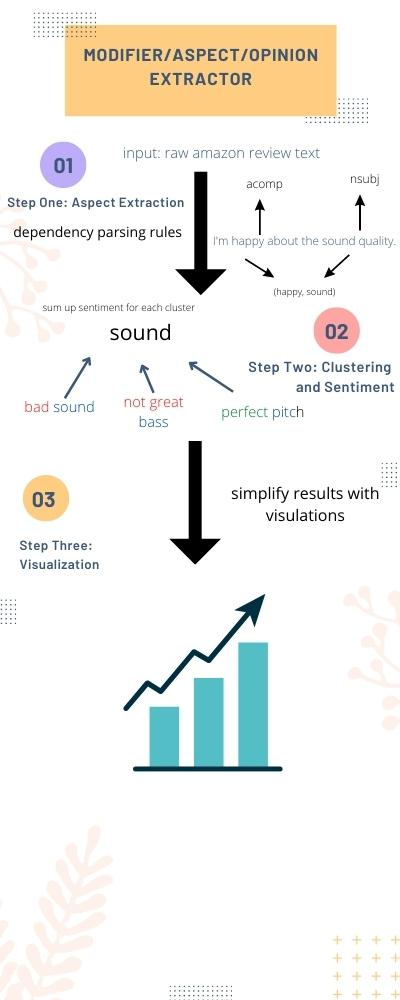

Below Is the pipeline design for spaCy and a description for the size and sources for the model loaded to run this project and parse the amazon reviews. 

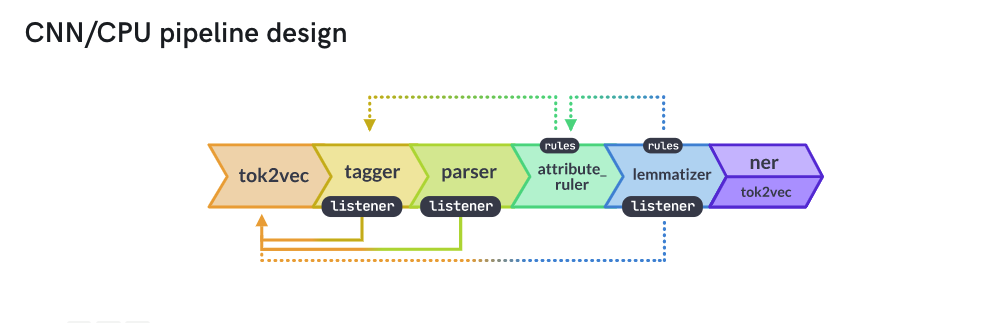

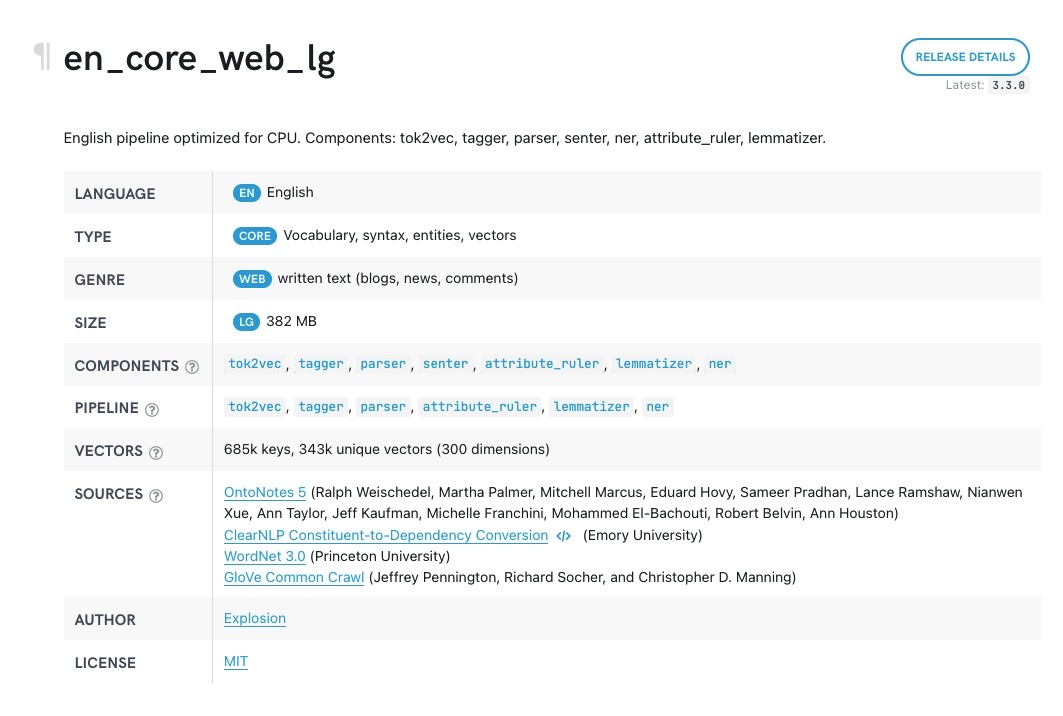

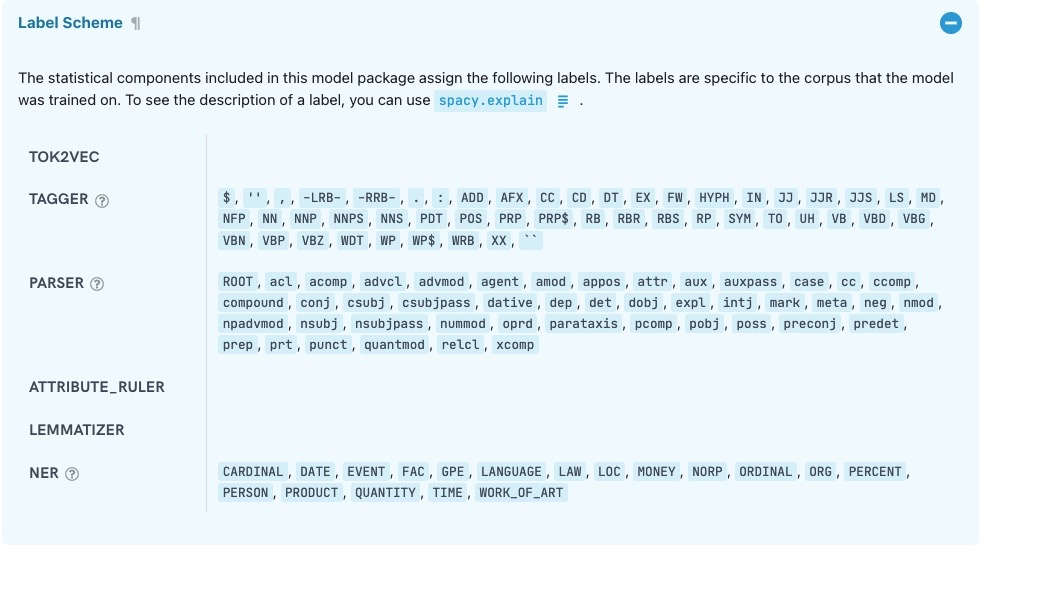

link: https://spacy.io/models/en




#### First Rule of Dependency Parser: The Aspect (A) token is a subject noun with a child Modifier (M) with a relation of amod (adjectival modifier). This just means that the aspect pair relation shares a simple adjective/noun relationship that can be extracted. However, there are certain caveats that need to be kept in mind when parsing the tree for this rule. First, it is important to check to see if there is an additional adverbial modifier that could adjust the intensity of the sentiment implied by the adjective and adverb combination in regards to the subject/aspect. This is important to keep in mind as we are taking advantage of NLTK vader sentiment intensity analyzer which can make use of additional adverbs to get a better understanding of sentiment. Another important thing to keep in mind when parsing for this rule is to be aware of the possibility of negating the adjective with ‘no’ as a determiner.

**Examples**

The comfortable headphones.

The most comfortable headphones.

No comfortable features. 



#### Second Rule of Dependency Parser: The aspect (A) is a child of something with a relation of nominal subject (nsubj.) while the modifier (M) is a child of the same something with a relationship of direct object. In this case, the adjective would be acting as the determiner of the clause. For simplicity's sake, it was determined to assume that each verb will have only one NSUBJ and DOBJ. This is a fair assumption for the application of this project, because even if there are multiple subjects, they will both be reviewing the same thing and will likely share the same opinion as it is written as a single review. For example, if an author were to say “My wife and I bought the awesome headphones”, we still only want to extract the keywords ‘awesome’ and ‘headphones.’

**Example**

I bought the awesome headphones.  

“I” =  nsubj 
“headphones” = dobj
“awesome” = det



#### THIRD RULE OF DEPENDENCY PARSE: The modifier (M) is a child of something with a relation of an adjectival complement (acomp), while the aspect (A) is a child of that same something with a relation of nominal subject (nsubj). See the example below.

**Example:** Barb is happy about the sound quality.

A: sound quality
M: happy

This rule needs to handle special cases in which the child is tagged as a modal verb with an auxiliary dependency. This would flag for phrases such as “the sound of the speakers could be better.” For special cases like this, the parser will add a negative prefix before scoring the aspect/modifier pairs for sentiment. 

**Example:** ‘This could be better.”
Would be extracted as the following:
A = “this”
M = ”not better”




 #### FOURTH RULE OF DEPENDENCY PARSE : The aspect (A) is a child of something with a relationship of passive nominal subject (nsubjpass) while the modifier (M) is a child of that same something with a relationship of adverbial modifier (advmod).  nsubjpass: A passive nominal subject is a noun phrase which is the syntactic subject of a passive clause. This step of the parser will also check to add a negative prefix before extracting and scoring for sentiment if necessary. 

The modifier is an adverbial modifier to a passive verb. 

**EXAMPLE:** The headphones died quickly

A: headphones
M: modifier

 

 #### FIFTH RULE OF DEPENDENCY PARSE: The aspect (A) is a child of the modifier with a relationship of nominal subject, while the modifier has a child with a relation of copula(cop).
Here the parser is looking for the complement of a copular verb. An often used copula verb is the word “is,” as in the phrase “Bill is big.”

    #Assumption - A verb will have only one NSUBJ and DOBJ

cop: copula A copula is the relation between the complement of a copular verb and the copular verb. (We normally take a copula as a dependent of its complement.

**Example:**

The sound is awesome.

A: sound
M: awesome


#### SIXTH RULE OF DEPENDENCY PARSE: Aspect/modifier are children of an interjection.
    ## M - Sentiment modifier || A - Aspect
    ## INTJ (interjections like bravo, great etc)


**Example:** Bravo good headphones.

Aspect: headphones
Modifier: good



    ## SEVENTH RULE OF DEPENDENCY PARSE: This rule is similar to rule 5, but makes use of the attr (attribute) tag instead. It seems to function similarly, in which an attribute is considered a noun phrase following a copular verb. 

ATTR - link between a verb like 'is/seem/appear/became' and its complement
    ## Example: 'this is garbage' -> (this, garbage)


### All dependency parsing rules also account for named entitites

### Image taking from spaCy showing depency tree

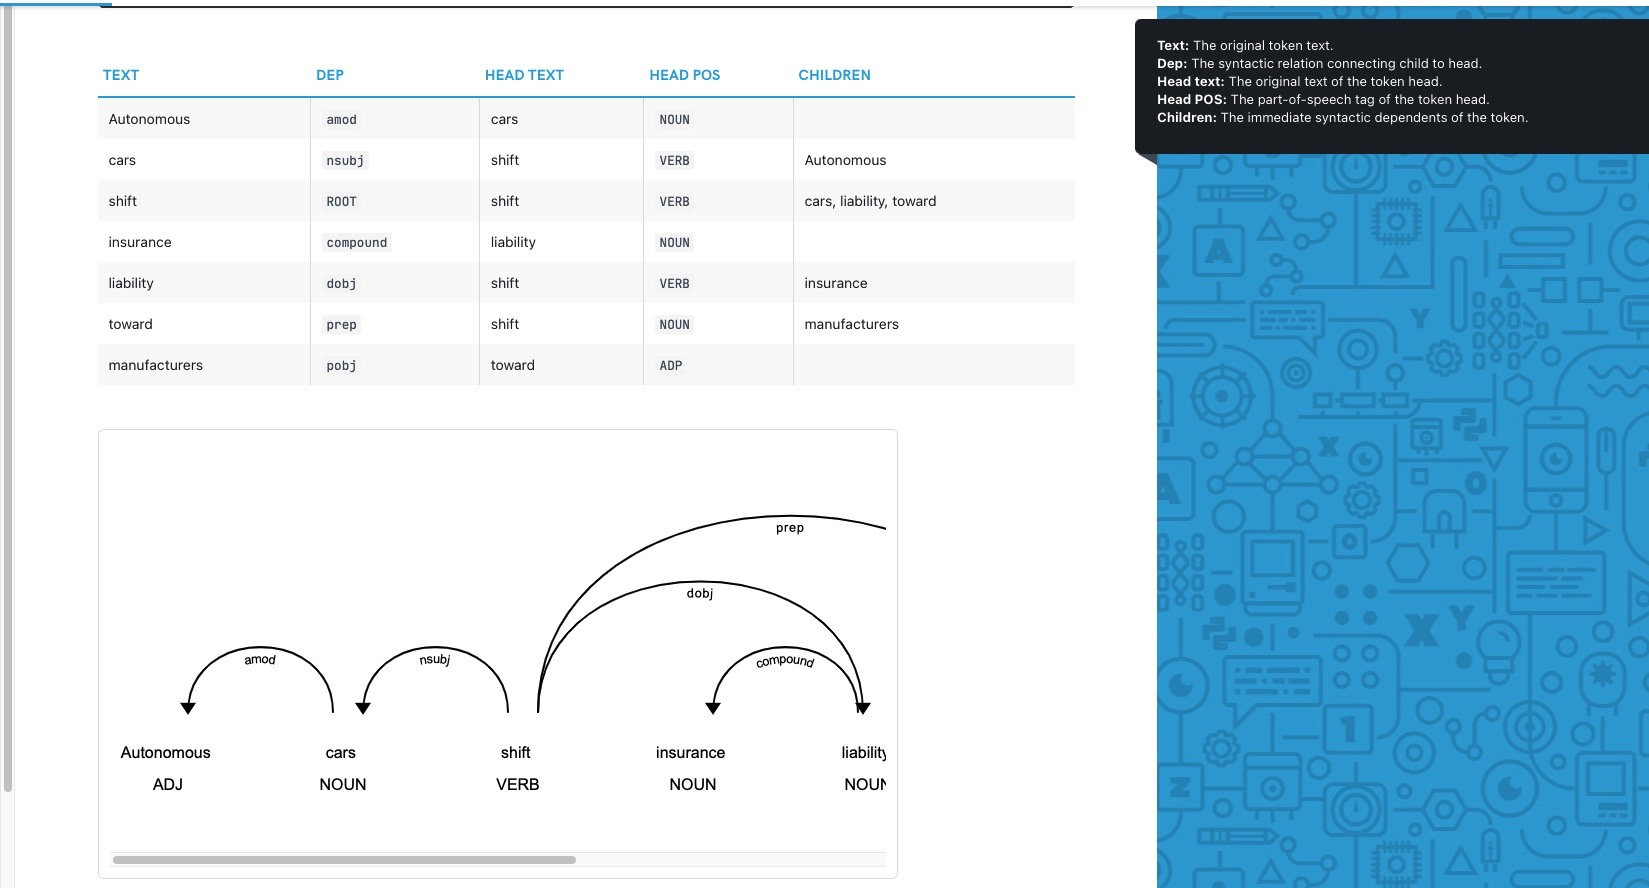

In [9]:
spacy.explain('acomp')

'adjectival complement'

https://spacy.io/usage/linguistic-features/#pos-tagging

DEPENDECY PARSING SECTION 

NAVIGATING THE TREE

NAMED ENTITY RECOGNITION


Please review the following sections above under the spaCy documentation for pos_tagging if you would like to get an understanding of how the parser was designed in spaCy. 

https://www.researchgate.net/publication/275828927_VADER_A_Parsimonious_Rule-based_Model_for_Sentiment_Analysis_of_Social_Media_Text


Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.


The Above reasearch paper was published on release of the VADER intensity sentiment analyzer. Please feel free to read to get a better understanding of how this tool was developed before being taken advantage of in this project. 

Clustering and Polarity Score
Every product have multiple reviews and hence will have a good number of aspect-modifier pairs. We also found different words used for a very similar aspect of the product. And therefore it becomes very important to group similar aspects into one cluster and thus providing a better accumulated insight of the product. Post clustering, polarity scores of the modifier were averaged out for every cluster to give a quantifiable explaination to opinion.

Word Vectors and Clustering
Polarity : The goods and the bads
Database : Integrating into the pipeline
Word Vectors and Clustering
The first time I was introduced to the concept of word vectors, I remember how amazed I was. Word vectors are a way of defining every word in terms of a bunch of numbers or vectors. This way of defining vectors corresponding to each word makes modelling relationships very intutive. For instance, in our case to find similar words, a simple distance function will signify how different or similar two words are. Using this very concept, we apply clustering on the word vectors of the extracted aspects. You can read more about word vectors here

The most famous implementation of words vectors is the word2vec project. However in our case, we used spaCy for vectorization as it provides fast and easy access to over a million unique word vectors, and its multi-task CNN model is trained on 'web' data and not 'newspaper' data as in other libraries like NLTK.

The word vectors were then grouped using K-Means clustering algorithm in Scikit-Learn. We experimented with other clustering algorithms such as DBSCAN. However, K-Means gave us optimal results with four clusters. The clusters were labeled based on the most frequently appearing word in each cluster.



The above figure captures how this process works using two sample reviews. The words in the middle are the cluster names. Do note that the cluster names are formed using more than two reviews. We have shown just two reviews here as samples.

Polarity : The goods and the bads
To determine polarity of the aspects, we used the VADER Sentiment Analysis tool which is part of the NLTK library. We chose this over other tools such as spaCy and TextBlob because of the accuracy and speed.


The polarity metric worked well for unambiguous positive or negative words; however, for some equivocal adjectives which require context for interpretation, the metric did not give an accurate value. A more contextual approach would make more sense in this case.

Database : Integrating into the pipeline
A parallel challenge to every piece of the project was scaling for the huge data we were handling. To make it easier for the UI to pull data and ensure that it's easier to keep updating the model results in future as we run it on more data, we hosted our model results on a Microsoft SQL Server database.

We are hosting the database on AWS to store the product, review, aspect and cluster data, and aggregate the polarity. Based on the results obtained from the model, we imported data into the database using Sequelize. A Node.js server was set up in the AWS machine which accepts requests with the product ID, and returns the query results needed for the visualizations.

One can find the whole codebase on the github repository.

### Detecting Product Aspects

In [10]:
display(spacy.explain('nsubjpass'))
display(spacy.explain('cop'))
display(spacy.explain('INTJ'))
spacy.explain('attr')

'nominal subject (passive)'

'copula'

'interjection'

'attribute'

TABLE OF REFERENCE:

AMOD:
adjectival modifier(link here)

ADVMOD:
 adverbial modifier
 example: Genetically Modified Food, Less often

NSUBJ: Nominal Subject
"Nominal subject (nsubj) is a nominal which is the syntactic subject and the proto-agent of a clause. That is, it is in the position that passes typical grammatical test for subjecthood, and this argument is the more agentive, the do-er, or the proto-agent of the clause. This nominal may be headed by a noun, or it may be a pronoun or relative pronoun or, in ellipsis contexts, other things such as an adjective."

DOBJ:
The direct object of a VP is the noun phrase which is the (accusative) object of the verb.


DET: determiner
The English DET covers most cases of Penn Treebank DT, PDT, WDT. However, when a Penn Treebank word with one of these tags stands alone as a noun phrase rather than modifying another word, then it becomes PRON.
 
 ACOMP: 
adjective complement
a phrase that modifies an adjective.


cop: 
copula
A cop (copula) is the relation of a function word used to link a subject to a nonverbal predicate, including the expression of identity predication (e.g. sentences like “Kim is the President”). It is often a verb but nonverbal (pronominal) copulas are also frequent in the world’s languages. Verbal copulas are tagged AUX, not VERB. Pronominal copulas are tagged PRON or DET.

INTJ: interjection
Definition
An interjection is a word that is used most often as an exclamation or part of an exclamation. It typically expresses an emotional reaction, is not syntactically related to other accompanying expressions, and may include a combination of sounds not otherwise found in the language.

Examples
psst
ouch
bravo
hello


attr:
attribute





In [11]:
def apply_extraction(row,nlp=nlp,sid=sid):
    review_body = row['review_body']
#     review_id = row['review_id']
#     review_marketplace = row['marketplace']
#     customer_id = row['customer_id']
#     product_id = row['product_id']
#     product_parent = row['product_parent']
#     product_title = row['product_title']
#     product_category = row['product_category']
#     date = str(row['review_date'])
#     star_rating = row['star_rating']
#     url = add_amazonlink(product_id)



    doc=nlp(review_body)


    ## FIRST RULE OF DEPENDANCY PARSE -
    ## M - Sentiment modifier || A - Aspect
    ## RULE = M is child of A with a relationshion of amod(adjectival modifier)
    ner_heads = {ent.root.idx: ent for ent in doc.ents}
    rule1_pairs = []
    for token in doc:
        A = "999999"
        M = "999999"
        if token.dep_ == "amod" and not token.is_stop:
            M = token.text
            if token.head in ner_heads:
                A = ner_heads[token.head].text
            else:
                A = token.head.text

            # add adverbial modifier of adjective (e.g. '*most* comfortable headphones')
            M_children = token.children
            for child_m in M_children:
                if(child_m.dep_ == "advmod"):
                    M_hash = child_m.text
                    M = M_hash + " " + M
                    break

            # negation in adjective, the "no" keyword is a 'det' of the noun (e.g. *no* interesting characters)
            A_children = token.head.children
            for child_a in A_children:
                if(child_a.dep_ == "det" and child_a.text == 'no'):
                    neg_prefix = 'not'
                    M = neg_prefix + " " + M
                    break

        if(A != "999999" and M != "999999"):
            rule1_pairs.append((A, M,sid.polarity_scores(token.text)['compound'],1))

    ## SECOND RULE OF DEPENDANCY PARSE -
    ## M - Sentiment modifier || A - Aspect
    #Direct Object - A is a child of something with relationship of nsubj, while
    # M is a child of the same something with relationship of dobj
    #Assumption - A verb will have only one NSUBJ and DOBJ
#     ner_heads = {ent.root.idx: ent for ent in doc.ents}
    rule2_pairs = []
    for token in doc:
        children = token.children
        A = "999999"
        M = "999999"
        add_neg_pfx = False
        for child in children :
            if(child.dep_ == "nsubj" and not child.is_stop):
                if child.idx in ner_heads:
                    A = ner_heads[child.idx].text
                else:
                    A = child.text
                # check_spelling(child.text)

            if((child.dep_ == "dobj" and child.pos_ == "ADJ") and not child.is_stop):
                M = child.text
                #check_spelling(child.text)

            if(child.dep_ == "neg"):
                neg_prefix = child.text
                add_neg_pfx = True

    if (add_neg_pfx and M != "999999"):
        M = neg_prefix + " " + M

        if(A != "999999" and M != "999999"):
            rule2_pairs.append((A, M,sid.polarity_scores(M)['compound'],2))


    ## THIRD RULE OF DEPENDANCY PARSE -
    ## M - Sentiment modifier || A - Aspect
    ## Adjectival Complement - A is a child of something with relationship of nsubj, while
    ## M is a child of the same something with relationship of acomp
    ## Assumption - A verb will have only one NSUBJ and DOBJ
    ## "The sound of the speakers would be better. The sound of the speakers could be better" - handled using AUX dependency


    rule3_pairs = []

    for token in doc:

        children = token.children
        A = "999999"
        M = "999999"
        add_neg_pfx = False
        for child in children :
            if(child.dep_ == "nsubj" and not child.is_stop):
                if child.idx in ner_heads:
                    A = ner_heads[child.idx].text
                else:
                    A = child.text
                # check_spelling(child.text)

            if(child.dep_ == "acomp" and not child.is_stop):
                M = child.text

            # example - 'this could have been better' -> (this, not better)
            if(child.dep_ == "aux" and child.tag_ == "MD"):
                neg_prefix = "not"
                add_neg_pfx = True

            if(child.dep_ == "neg"):
                neg_prefix = child.text
                add_neg_pfx = True

        if (add_neg_pfx and M != "999999"):
            M = neg_prefix + " " + M
                #check_spelling(child.text)

        if(A != "999999" and M != "999999"):
            rule3_pairs.append((A, M, sid.polarity_scores(M)['compound'],3))

    ## FOURTH RULE OF DEPENDENCY PARSE -
    ## M - Sentiment modifier || A - Aspect

    #Adverbial modifier to a passive verb - A is a child of something with relationship of nsubjpass, while
    # M is a child of the same something with relationship of advmod

    #Assumption - A verb will have only one NSUBJ and DOBJ

    rule4_pairs = []
    for token in doc:


        children = token.children
        A = "999999"
        M = "999999"
        add_neg_pfx = False
        for child in children :
            if((child.dep_ == "nsubjpass" or child.dep_ == "nsubj") and not child.is_stop):
                if child.idx in ner_heads:
                    A = ner_heads[child.idx].text
                else:
                    A = child.text
                # check_spelling(child.text)

            if(child.dep_ == "advmod" and not child.is_stop):
                M = child.text
                M_children = child.children
                for child_m in M_children:
                    if(child_m.dep_ == "advmod"):
                        M_hash = child_m.text
                        M = M_hash + " " + child.text
                        break
                #check_spelling(child.text)

            if(child.dep_ == "neg"):
                neg_prefix = child.text
                add_neg_pfx = True

        if (add_neg_pfx and M != "999999"):
            M = neg_prefix + " " + M

        if(A != "999999" and M != "999999"):
            rule4_pairs.append((A, M,sid.polarity_scores(M)['compound'],4)) # )


    ## FIFTH RULE OF DEPENDANCY PARSE -
    ## M - Sentiment modifier || A - Aspect

    #Complement of a copular verb - A is a child of M with relationship of nsubj, while
    # M has a child with relationship of cop

    #Assumption - A verb will have only one NSUBJ and DOBJ

    rule5_pairs = []
    for token in doc:
        children = token.children
        A = "999999"
        buf_var = "999999"
        for child in children :
            if(child.dep_ == "nsubj" and not child.is_stop):
                if child.idx in ner_heads:
                    A = ner_heads[child.idx].text
                else:
                    A = child.text
                
                # check_spelling(child.text)

            if(child.dep_ == "cop" and not child.is_stop):
                buf_var = child.text
                #check_spelling(child.text)

        if(A != "999999" and buf_var != "999999"):
            rule5_pairs.append((A, token.text,sid.polarity_scores(token.text)['compound'],5))


    ## SIXTH RULE OF DEPENDENCY PARSE -
    ## M - Sentiment modifier || A - Aspect
    ## INTJ (interjections like bravo, great etc)


    rule6_pairs = []
    for token in doc:
        children = token.children
        A = "999999"
        M = "999999"
        if(token.pos_ == "INTJ" and not token.is_stop):
            for child in children :
                if(child.dep_ == "nsubj" and not child.is_stop):
                    M = token.text
                    if child.idx in ner_heads:
                        A = ner_heads[child.idx].text
                    else:
                        A = child.text
                    # check_spelling(child.text)

        if(A != "999999" and M != "999999"):
            rule6_pairs.append((A, M,sid.polarity_scores(M)['compound'],6))


    ## SEVENTH RULE OF DEPENDENCY PARSE -
    ## M - Sentiment modifier || A - Aspect
    ## ATTR - link between a verb like 'be/seem/appear' and its complement
    ## Example: 'this is garbage' -> (this, garbage)

    rule7_pairs = []
    for token in doc:
        children = token.children
        A = "999999"
        M = "999999"
        add_neg_pfx = False
        for child in children :
            if(child.dep_ == "nsubj" and not child.is_stop):
                if child.idx in ner_heads:
                    A = ner_heads[child.idx].text
                else:
                    A = child.text
                # check_spelling(child.text)

            if((child.dep_ == "attr") and not child.is_stop):
                M = child.text
                #check_spelling(child.text)

            if(child.dep_ == "neg"):
                neg_prefix = child.text
                add_neg_pfx = True

        if (add_neg_pfx and M != "999999"):
            M = neg_prefix + " " + M

        if(A != "999999" and M != "999999"):
            rule7_pairs.append((A, M,sid.polarity_scores(M)['compound'],7))



    aspects = []

    aspects = rule1_pairs + rule2_pairs + rule3_pairs +rule4_pairs +rule5_pairs + rule6_pairs + rule7_pairs
    prod_pronouns = ['it', 'this', 'they']

    # replace all instances of "it", "this" and "they" with "product"
    aspects = [(A,M,P,r) if A not in prod_pronouns else ("product",M,P,r) for A,M,P,r in aspects]

#     dic = {"review_id" : review_id , "aspect_pairs" : aspects, "review_marketplace" : review_marketplace
#     , "customer_id" : customer_id, "product_id" : product_id, "product_parent" : product_parent,
#     "product_title" : product_title, "product_category" : product_category, "date" : date, "star_rating" : star_rating, "url" : url}
    
    
    return aspects



def remove_digits(x):
    return " ".join([t for t in x.split() if not t.isdigit()])



def get_word_vectors(unique_aspects, nlp=nlp):
    asp_vectors = []
    for aspect in unique_aspects:
        # print(aspect)
        token = nlp(aspect)
        asp_vectors.append(token.vector)
    return asp_vectors


def get_aspect_freq_map(aspects):
    aspect_freq_map = defaultdict(int)
    for asp in aspects:
        aspect_freq_map[asp] += 1
    return aspect_freq_map



NUM_CLUSTERS = 4

def get_word_cluster_labels(unique_aspects, nlp=nlp):
    # print("Found {} unique aspects for this product".format(len(unique_aspects)))
    asp_vectors = get_word_vectors(unique_aspects, nlp)
    # n_clusters = min(NUM_CLUSTERS,len(unique_aspects))
    if len(unique_aspects) <= NUM_CLUSTERS:
        # print("Too few aspects ({}) found. No clustering required...".format(len(unique_aspects)))
        return list(range(len(unique_aspects)))

    # print("Running k-means clustering...")
    n_clusters = NUM_CLUSTERS
    kmeans = cluster.KMeans(n_clusters=n_clusters)
    kmeans.fit(asp_vectors)
    labels = kmeans.labels_
    # dbscan = cluster.DBSCAN(eps = 0.2, min_samples = 2).fit(asp_vectors)
    # labels = dbscan.labels_

    # print("Finished running k-means clustering with {} labels".format(len(labels)))
    # print(labels)
    return labels



def get_cluster_names_map(asp_to_cluster_map, aspect_freq_map):
    cluster_id_to_name_map = defaultdict()
    # cluster_to_asp_map = defaultdict()
    clusters = set(asp_to_cluster_map.values())
    for i in clusters:
        this_cluster_asp = [k for k,v in asp_to_cluster_map.items() if v == i]
        filt_freq_map = {k:v for k,v in aspect_freq_map.items() if k in this_cluster_asp}
        filt_freq_map = sorted(filt_freq_map.items(), key = lambda x: x[1], reverse = True)
        cluster_id_to_name_map[i] = filt_freq_map

        # cluster_to_asp_map[i] = this_cluster_asp

    # print(cluster_to_asp_map)
    # print(cluster_id_to_name_map)
    return cluster_id_to_name_map



#Two master functions below for applying above functions


def extract_aspect_sentiment_tuples(df):
    df = master_preprocess(df)
    df = df.loc[df['wordcounts'] > 10].copy()
    df.reset_index(drop=True, inplace=True)
    df['aspect_tups'] = df.apply(apply_extraction, axis=1)
    df = df.explode('aspect_tups').copy()
    df.dropna(inplace=True)
    df['asp'] = df['aspect_tups'].apply(lambda x: x[0])
    df['modifier'] = df['aspect_tups'].apply(lambda x: x[1])
    df['modifier_sentiment'] = df['aspect_tups'].apply(lambda x: x[2])
    df['rule_number'] = df['aspect_tups'].apply(lambda x: x[3])
    return df


#This function will work with input from user
#to find best possible label name for clusters
def get_cluster_name_inputs(df):
    print('loading....')
    aspect_freq_map = get_aspect_freq_map(df['asp'].values)
    unique_asp_array = df['asp'].unique()
    mapped_labels = get_word_cluster_labels(unique_asp_array)
    asp_labels_map = dict(zip(unique_asp_array, mapped_labels))
    label_names_map = get_cluster_names_map(asp_labels_map, aspect_freq_map)
    
    df['asp_cluster_label'] = df['asp'].map(asp_labels_map)
    
    print("write misc if low counts and special characters")
    print("the top word is usually the best fit")
   
    display(label_names_map[0][:10])
    print("Pick a category for above words: ")
    clust_0 = input()

    display(label_names_map[1][:10])
    print("Pick a category for above words: ")
    clust_1 = input()

    display(label_names_map[2][:10])
  
    print("Pick a category for above words: ")
    clust_2 = input()

    display(label_names_map[3][:10])
    print("Pick a category for above words: ")
    clust_3 = input()

    clusters = [clust_0] + [clust_1] + [clust_2] + [clust_3]


    name_clust_dict = {0: clusters[0],
                       1: clusters[1],
                       2: clusters[2],
                       3: clusters[3]
                      }

    

    df['cluster_name'] = df['asp_cluster_label'].map(name_clust_dict)
    
    return df

In [12]:
df_senti = extract_aspect_sentiment_tuples(df)
df_senti.head()

,review_id,star_rating,review_body,wordcounts,aspect_tups,asp,modifier,modifier_sentiment,rule_number
0,RA8R84N9JMZLD,3,"My Dad loves this, only issue is charging, it ...",32,"(connection, proper, 0.0, 1)",connection,proper,0.0000,1
2,R1KL6IIDB77A2O,4,I would not have paid the original price for t...,58,"(price, original, 0.3182, 1)",price,original,0.3182,1
2,R1KL6IIDB77A2O,4,I would not have paid the original price for t...,58,"(bit, little, 0.0, 1)",bit,little,0.0000,1
2,R1KL6IIDB77A2O,4,I would not have paid the original price for t...,58,"(star, how durable, 0.0, 1)",star,how durable,0.0000,1
2,R1KL6IIDB77A2O,4,I would not have paid the original price for t...,58,"(price, lower, -0.296, 1)",price,lower,-0.2960,1


In [13]:
df_senti_predicted = df_senti.loc[:, ['modifier', 'asp', 'modifier_sentiment']]

df_senti_predicted.head()

df_senti_predicted.loc[df_senti_predicted['modifier_sentiment'] < -.5, 'sentiment'] = 'Very Negative'
df_senti_predicted.loc[(df_senti_predicted['modifier_sentiment'] >= -.5) & (df_senti_predicted['modifier_sentiment'] < 0), 'sentiment'] = 'Negative'
df_senti_predicted.loc[df_senti_predicted['modifier_sentiment'] == 0, 'sentiment'] = 'Neutral'
df_senti_predicted.loc[(df_senti_predicted['modifier_sentiment'] > 0) & (df_senti_predicted['modifier_sentiment'] <= 0.5), 'sentiment'] = 'Positive'
df_senti_predicted.loc[df_senti_predicted['modifier_sentiment'] > 0.5, 'sentiment'] = 'Very Positive'

df_senti_predicted.head()

df_senti_predicted['tup_pair_p'] = list(zip(df_senti_predicted['modifier'],df_senti_predicted['asp']))

df_to_turk2 = df_senti_predicted.drop_duplicates(subset='tup_pair_p')

df_to_turk2.sort_values(by='asp')

,modifier,asp,modifier_sentiment,sentiment,tup_pair_p
1072,Able,,0.0000,Neutral,"(Able, )"
7660,Though bulky,,0.0000,Neutral,"(Though bulky, )"
1900,Only negative,,-0.5719,Very Negative,"(Only negative, )"
6809,Really disappointed,,-0.4767,Negative,"(Really disappointed, )"
6810,Otherwise excellent,,0.5719,Very Positive,"(Otherwise excellent, )"
...,...,...,...,...,...
5475,fake,youout,-0.4767,Negative,"(fake, youout)"
3941,past,yrs,0.0000,Neutral,"(past, yrs)"
6229,dead,zone,-0.6486,Very Negative,"(dead, zone)"
197,sweet,zone,0.4588,Positive,"(sweet, zone)"


In [14]:
df_to_turk2 = df_senti_predicted.drop_duplicates(subset='tup_pair_p')
df_to_turk2.loc[:, ['modifier', 'asp']].to_csv('data/turk_data2.csv', index=False)

In [ ]:
# df_batch = pd.read_csv('data/batch_results1.csv')

In [20]:
df1 = pd.read_csv("data/batch1_results.csv")
df2 = pd.read_csv("data/batch2_results.csv")
df3 = pd.read_csv("data/batch3_results.csv")
df4 = pd.read_csv("data/batch4_results.csv")
# df_lab = pd.read_csv("data/locally_sourced_labels.csv") 

In [21]:
display(df1.info())
display(df2.info())
display(df3.info())
display(df4.info())
# df_lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   HITId                        1020 non-null   object 
 1   HITTypeId                    1020 non-null   object 
 2   Title                        1020 non-null   object 
 3   Description                  1020 non-null   object 
 4   Keywords                     1020 non-null   object 
 5   CreationTime                 1020 non-null   object 
 6   MaxAssignments               1020 non-null   int64  
 7   RequesterAnnotation          1020 non-null   object 
 8   AssignmentDurationInSeconds  1020 non-null   int64  
 9   AutoApprovalDelayInSeconds   1020 non-null   int64  
 10  Expiration                   1020 non-null   object 
 11  NumberOfSimilarHITs          0 non-null      float64
 12  LifetimeInSeconds            0 non-null      float64
 13  AssignmentId      

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   HITId                        153 non-null    object 
 1   HITTypeId                    153 non-null    object 
 2   Title                        153 non-null    object 
 3   Description                  153 non-null    object 
 4   Keywords                     153 non-null    object 
 5   CreationTime                 153 non-null    object 
 6   MaxAssignments               153 non-null    int64  
 7   RequesterAnnotation          153 non-null    object 
 8   AssignmentDurationInSeconds  153 non-null    int64  
 9   AutoApprovalDelayInSeconds   153 non-null    int64  
 10  Expiration                   153 non-null    object 
 11  NumberOfSimilarHITs          0 non-null      float64
 12  LifetimeInSeconds            0 non-null      float64
 13  AssignmentId        

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921 entries, 0 to 1920
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   HITId                        1921 non-null   object 
 1   HITTypeId                    1921 non-null   object 
 2   Title                        1921 non-null   object 
 3   Description                  1921 non-null   object 
 4   Keywords                     1921 non-null   object 
 5   CreationTime                 1921 non-null   object 
 6   MaxAssignments               1921 non-null   int64  
 7   RequesterAnnotation          1921 non-null   object 
 8   AssignmentDurationInSeconds  1921 non-null   int64  
 9   AutoApprovalDelayInSeconds   1921 non-null   int64  
 10  Expiration                   1921 non-null   object 
 11  NumberOfSimilarHITs          0 non-null      float64
 12  LifetimeInSeconds            0 non-null      float64
 13  AssignmentId      

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3229 entries, 0 to 3228
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   HITId                        3229 non-null   object 
 1   HITTypeId                    3229 non-null   object 
 2   Title                        3229 non-null   object 
 3   Description                  3229 non-null   object 
 4   Keywords                     3229 non-null   object 
 5   CreationTime                 3229 non-null   object 
 6   MaxAssignments               3229 non-null   int64  
 7   RequesterAnnotation          3229 non-null   object 
 8   AssignmentDurationInSeconds  3229 non-null   int64  
 9   AutoApprovalDelayInSeconds   3229 non-null   int64  
 10  Expiration                   3229 non-null   object 
 11  NumberOfSimilarHITs          0 non-null      float64
 12  LifetimeInSeconds            0 non-null      float64
 13  AssignmentId      

None

In [22]:
df_turk = pd.concat([df1,df2,df3, df4])

In [23]:
df_turk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6323 entries, 0 to 3228
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   HITId                        6323 non-null   object 
 1   HITTypeId                    6323 non-null   object 
 2   Title                        6323 non-null   object 
 3   Description                  6323 non-null   object 
 4   Keywords                     6323 non-null   object 
 5   CreationTime                 6323 non-null   object 
 6   MaxAssignments               6323 non-null   int64  
 7   RequesterAnnotation          6323 non-null   object 
 8   AssignmentDurationInSeconds  6323 non-null   int64  
 9   AutoApprovalDelayInSeconds   6323 non-null   int64  
 10  Expiration                   6323 non-null   object 
 11  NumberOfSimilarHITs          0 non-null      float64
 12  LifetimeInSeconds            0 non-null      float64
 13  AssignmentId      

In [24]:
df_turk = df_turk.loc[:, ['Input.Modifier', 'Input.Aspect',  'Answer.sentiment.label']]

In [25]:
df_turk.dropna(inplace=True)

In [26]:
df_turk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6107 entries, 0 to 3228
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Input.Modifier          6107 non-null   object
 1   Input.Aspect            6107 non-null   object
 2   Answer.sentiment.label  6107 non-null   object
dtypes: object(3)
memory usage: 190.8+ KB


In [27]:
df_senti.head()

,review_id,star_rating,review_body,wordcounts,aspect_tups,asp,modifier,modifier_sentiment,rule_number
0,RA8R84N9JMZLD,3,"My Dad loves this, only issue is charging, it ...",32,"(connection, proper, 0.0, 1)",connection,proper,0.0000,1
2,R1KL6IIDB77A2O,4,I would not have paid the original price for t...,58,"(price, original, 0.3182, 1)",price,original,0.3182,1
2,R1KL6IIDB77A2O,4,I would not have paid the original price for t...,58,"(bit, little, 0.0, 1)",bit,little,0.0000,1
2,R1KL6IIDB77A2O,4,I would not have paid the original price for t...,58,"(star, how durable, 0.0, 1)",star,how durable,0.0000,1
2,R1KL6IIDB77A2O,4,I would not have paid the original price for t...,58,"(price, lower, -0.296, 1)",price,lower,-0.2960,1


In [28]:
df_senti_predicted = df_senti.loc[:, ['modifier', 'asp', 'modifier_sentiment']]

In [29]:
df_senti_predicted.head()

,modifier,asp,modifier_sentiment
0,proper,connection,0.0000
2,original,price,0.3182
2,little,bit,0.0000
2,how durable,star,0.0000
2,lower,price,-0.2960


In [30]:
df_senti_predicted.loc[df_senti_predicted['modifier_sentiment'] < -.5, 'sentiment'] = 'Very Negative'
df_senti_predicted.loc[(df_senti_predicted['modifier_sentiment'] >= -.5) & (df_senti_predicted['modifier_sentiment'] < 0), 'sentiment'] = 'Negative'
df_senti_predicted.loc[df_senti_predicted['modifier_sentiment'] == 0, 'sentiment'] = 'Neutral'
df_senti_predicted.loc[(df_senti_predicted['modifier_sentiment'] > 0) & (df_senti_predicted['modifier_sentiment'] <= 0.5), 'sentiment'] = 'Positive'
df_senti_predicted.loc[df_senti_predicted['modifier_sentiment'] > 0.5, 'sentiment'] = 'Very Positive'

In [31]:
df_senti_predicted.head()

,modifier,asp,modifier_sentiment,sentiment
0,proper,connection,0.0000,Neutral
2,original,price,0.3182,Positive
2,little,bit,0.0000,Neutral
2,how durable,star,0.0000,Neutral
2,lower,price,-0.2960,Negative


In [32]:
df_senti_predicted['tup_pair_p'] = list(zip(df_senti_predicted['modifier'],df_senti_predicted['asp']))

In [33]:
df_senti_predicted.sort_values(by='asp')

,modifier,asp,modifier_sentiment,sentiment,tup_pair_p
6080,right,,0.0000,Neutral,"(right, )"
7059,Useful,,0.4404,Positive,"(Useful, )"
7872,Sure,,0.3182,Positive,"(Sure, )"
5745,Inexpensive,,0.0000,Neutral,"(Inexpensive, )"
3512,Wonderful,,0.5719,Very Positive,"(Wonderful, )"
...,...,...,...,...,...
5475,fake,youout,-0.4767,Negative,"(fake, youout)"
3941,past,yrs,0.0000,Neutral,"(past, yrs)"
197,sweet,zone,0.4588,Positive,"(sweet, zone)"
6229,dead,zone,-0.6486,Very Negative,"(dead, zone)"


In [34]:
df_turk.rename({'Input.Modifier': 'modifier', 
                        'Input.Aspect': 'asp',
                        'Answer.sentiment.label': 'sentiment_h'
                       }, axis=1, inplace=True)

In [35]:
df_turk.sort_values(by='asp')

,modifier,asp,sentiment_h
32,extra,$,Very Positive
115,more missing,1/2,Negative
646,single,1/8,Neutral
1659,stereo,1/8\\,Neutral
589,new,120s,Positive
...,...,...,...
3042,pair,years,Neutral
1031,plus,years,Positive
1878,past,years,Positive
2296,fake,youout,Very Negative


In [36]:
df_turk['tup_pair_h'] = list(zip(df_turk['modifier'],df_turk['asp']))

In [37]:
df_turk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6107 entries, 0 to 3228
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   modifier     6107 non-null   object
 1   asp          6107 non-null   object
 2   sentiment_h  6107 non-null   object
 3   tup_pair_h   6107 non-null   object
dtypes: object(4)
memory usage: 238.6+ KB


In [38]:
df_senti_predicted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35355 entries, 0 to 7875
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   modifier            35355 non-null  object 
 1   asp                 35355 non-null  object 
 2   modifier_sentiment  35355 non-null  float64
 3   sentiment           35355 non-null  object 
 4   tup_pair_p          35355 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.6+ MB


In [39]:
df_results = pd.merge(df_turk,
                      df_senti_predicted,
                      left_on=['tup_pair_h'],
                      right_on =['tup_pair_p'],
                      how='left'
                     )

In [40]:
df_results.drop_duplicates(subset='tup_pair_h', inplace=True)

In [41]:
df_results.head()

,modifier_x,asp_x,sentiment_h,tup_pair_h,modifier_y,asp_y,modifier_sentiment,sentiment,tup_pair_p
0,old,father,Neutral,"(old, father)",old,father,0.0,Neutral,"(old, father)"
16,wireless,headphones,Neutral,"(wireless, headphones)",wireless,headphones,0.0,Neutral,"(wireless, headphones)"
748,charging,rack,Neutral,"(charging, rack)",charging,rack,0.0,Neutral,"(charging, rack)"
752,also available,headphones,Very Positive,"(also available, headphones)",also available,headphones,0.0,Neutral,"(also available, headphones)"
753,impaired,husband,Negative,"(impaired, husband)",impaired,husband,0.0,Neutral,"(impaired, husband)"


In [43]:
display(df_results.sentiment_h.value_counts())
df_results.sentiment.value_counts()

Positive         1860
Neutral          1521
Very Positive     790
Negative          692
Very Negative     223
Name: sentiment_h, dtype: int64

Neutral          3309
Positive          763
Very Positive     523
Negative          397
Very Negative      88
Name: sentiment, dtype: int64

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

In [79]:
df_results2 = df_results.reset_index(drop=True)
df_results2.dropna(inplace=True)

In [91]:
matching_predictions = df_results2.loc[df_results2['sentiment_h'] == df_results2['sentiment']]
mismatching_predictions = df_results2.loc[df_results2['sentiment_h'] != df_results2['sentiment']]

In [92]:
matching_predictions

,modifier_x,asp_x,sentiment_h,tup_pair_h,modifier_y,asp_y,modifier_sentiment,sentiment,tup_pair_p
0,old,father,Neutral,"(old, father)",old,father,0.0000,Neutral,"(old, father)"
1,wireless,headphones,Neutral,"(wireless, headphones)",wireless,headphones,0.0000,Neutral,"(wireless, headphones)"
2,charging,rack,Neutral,"(charging, rack)",charging,rack,0.0000,Neutral,"(charging, rack)"
10,excellent,quality,Very Positive,"(excellent, quality)",excellent,quality,0.5719,Very Positive,"(excellent, quality)"
17,clear,cable,Positive,"(clear, cable)",clear,cable,0.3818,Positive,"(clear, cable)"
...,...,...,...,...,...,...,...,...,...
5074,n't anymore,stores,Neutral,"(n't anymore, stores)",n't anymore,stores,0.0000,Neutral,"(n't anymore, stores)"
5077,real,world,Neutral,"(real, world)",real,world,0.0000,Neutral,"(real, world)"
5079,terrific,response,Positive,"(terrific, response)",terrific,response,0.4767,Positive,"(terrific, response)"
5080,wireless,reviews,Neutral,"(wireless, reviews)",wireless,reviews,0.0000,Neutral,"(wireless, reviews)"


In [93]:
mismatching_predictions

,modifier_x,asp_x,sentiment_h,tup_pair_h,modifier_y,asp_y,modifier_sentiment,sentiment,tup_pair_p
3,also available,headphones,Very Positive,"(also available, headphones)",also available,headphones,0.0000,Neutral,"(also available, headphones)"
4,impaired,husband,Negative,"(impaired, husband)",impaired,husband,0.0000,Neutral,"(impaired, husband)"
5,second,set,Positive,"(second, set)",second,set,0.0000,Neutral,"(second, set)"
6,idea,product,Very Positive,"(idea, product)",idea,product,0.0000,Neutral,"(idea, product)"
7,proper,connection,Negative,"(proper, connection)",proper,connection,0.0000,Neutral,"(proper, connection)"
...,...,...,...,...,...,...,...,...,...
5078,thenoticable,hiss,Negative,"(thenoticable, hiss)",thenoticable,hiss,0.0000,Neutral,"(thenoticable, hiss)"
5081,passed,purchases,Positive,"(passed, purchases)",passed,purchases,0.0000,Neutral,"(passed, purchases)"
5083,Obviously,owners,Positive,"(Obviously, owners)",Obviously,owners,0.0000,Neutral,"(Obviously, owners)"
5084,Constant,sound,Very Positive,"(Constant, sound)",Constant,sound,0.0000,Neutral,"(Constant, sound)"


In [85]:
3139+1941

5080

In [84]:
df_results2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5080 entries, 0 to 5085
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   modifier_x          5080 non-null   object 
 1   asp_x               5080 non-null   object 
 2   sentiment_h         5080 non-null   object 
 3   tup_pair_h          5080 non-null   object 
 4   modifier_y          5080 non-null   object 
 5   asp_y               5080 non-null   object 
 6   modifier_sentiment  5080 non-null   float64
 7   sentiment           5080 non-null   object 
 8   tup_pair_p          5080 non-null   object 
dtypes: float64(1), object(8)
memory usage: 396.9+ KB


In [94]:
matching_predictions.sentiment.value_counts()

Neutral          1198
Positive          394
Very Positive     187
Negative          141
Very Negative      21
Name: sentiment, dtype: int64

In [95]:
mismatching_predictions.sentiment.value_counts()

Neutral          2111
Positive          369
Very Positive     336
Negative          256
Very Negative      67
Name: sentiment, dtype: int64

In [145]:
arr = df_turk['tup_pair_h'].value_counts()[df_turk['tup_pair_h'].value_counts() > 10].keys()

In [147]:
df_turk2 = df_turk[df_turk["tup_pair_h"].isin(arr)]

In [218]:
turk_graph_ind = df_turk2['tup_pair_h'].value_counts()[:5].index

In [219]:
turk_graph_ind

Index([      ('sound', 'quality'), ('wireless', 'headphones'),
              ('good', 'quality'),         ('great', 'sound'),
             ('great', 'quality')],
      dtype='object')

In [313]:
def variance_visualizer(df, tup):
    graph_s = df[df['tup_pair_p'] == tup]['sentiment'].value_counts()
    fig = plt.figure(figsize=(15,8))


    ax = graph_s.plot.bar()

    #ADD TOTAL NUMBER OF VOTES
    fig.text(0.9, 
             0.9,
             s=f'Total Votes: {(graph_s.sum())}',
             ha='center', 
             va='center',
             transform=ax.transAxes,
             size=20
            );

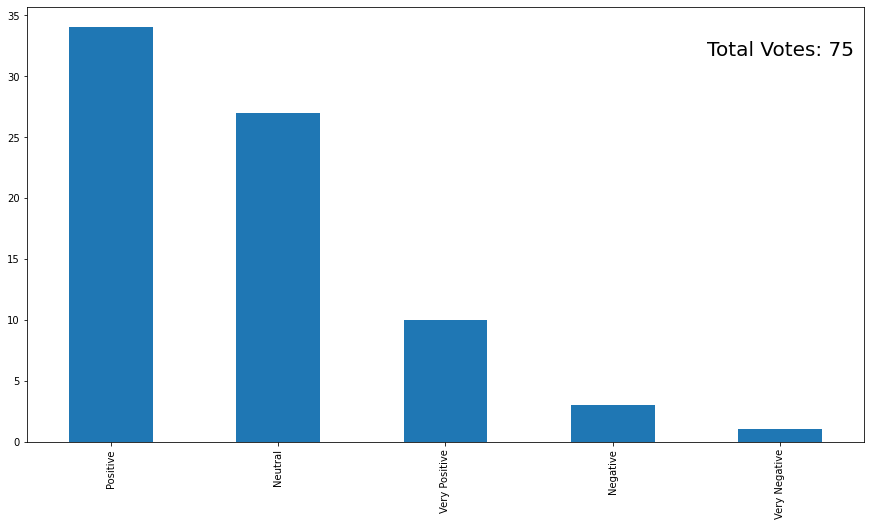

In [311]:
variance_visualizer(df_turk2, ('sound', 'quality'))

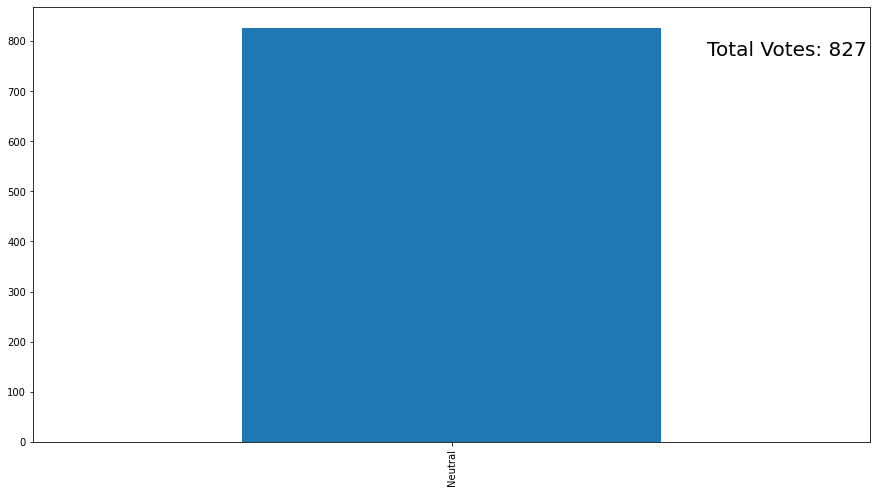

In [314]:
variance_visualizer(df_senti2, ('sound', 'quality'))

In [247]:
tup=('good', 'quality')

In [271]:
graph_s = df_turk2[df_turk2['tup_pair_h'] == tup]['sentiment_h'].value_counts()

In [277]:
graph_s.sum()

26

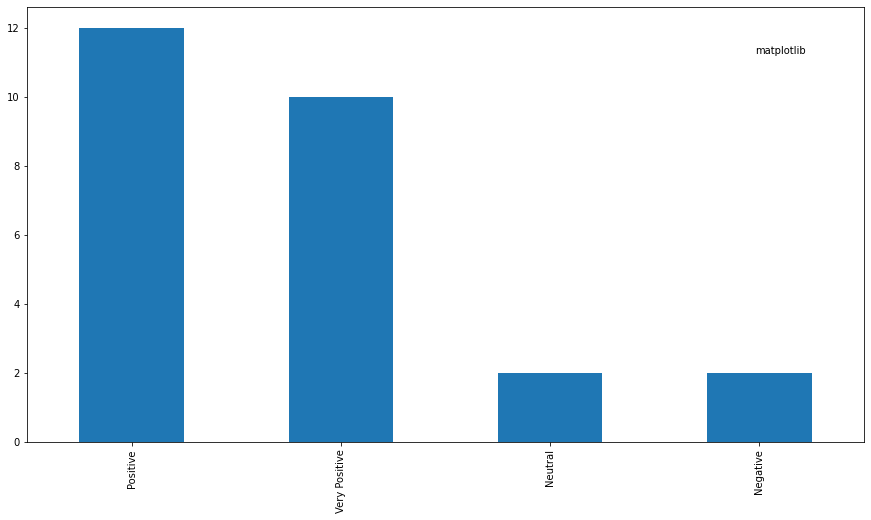

In [305]:
fig = plt.figure(figsize=(15,8))

#add legend key
plt.text(1,1, verticalalignment='top',
         s=f'Total Votes: {(graph_s.sum())}',
        size=12, transform=ax.transAxes)
graph_s.plot.bar()

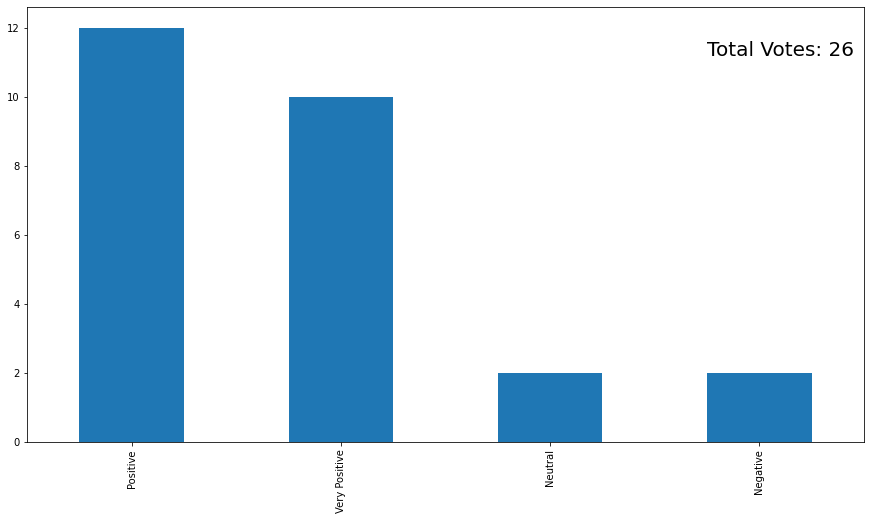

In [309]:
fig = plt.figure(figsize=(15,8))


ax = graph_s.plot.bar()

#ADD TOTAL NUMBER OF VOTES
fig.text(0.9, 
         0.9,
         s=f'Total Votes: {(graph_s.sum())}',
         ha='center', 
         va='center',
         transform=ax.transAxes,
         size=20
        );

In [214]:
graph_h1 = df_turk2[df_turk2['tup_pair_h'] == ('sound', 'quality')]['sentiment_h'].value_counts()

In [216]:
graph_s

Positive         34
Neutral          27
Very Positive    10
Negative          3
Very Negative     1
Name: sentiment_h, dtype: int64

/Users/dylandey/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment_h', ylabel='count'>

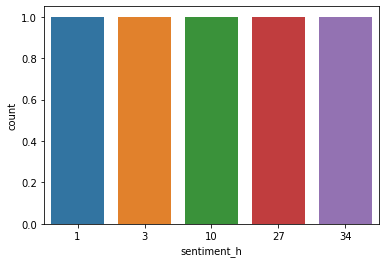

In [217]:
sns.countplot(graph_s)

In [182]:
arr3 = df_senti_predicted['tup_pair_p'].value_counts()[df_senti_predicted['tup_pair_p'].value_counts() > 10].keys()

In [184]:
df_senti2 = df_senti_predicted[df_senti_predicted["tup_pair_p"].isin(arr3)]

In [202]:
df_senti2['tup_pair_p'].value_counts()[:5].index

Index([      ('sound', 'quality'), ('wireless', 'headphones'),
              ('good', 'quality'),         ('great', 'sound'),
               ('clear', 'sound')],
      dtype='object')

In [193]:
graph_s2 = df_senti2[df_senti2['tup_pair_p'] == ('wireless', 'headphones')]['sentiment'].value_counts()

/Users/dylandey/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

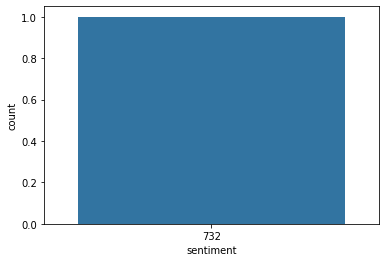

In [194]:
sns.countplot(graph_s2)

In [ ]:
# df = pd.read_csv('data/modifier_aspect_unlabeled.csv')

In [ ]:
# df_turk = df2.loc[:, ['Input.Modifier', 'Input.Aspect',  'Answer.sentiment.label']]

In [ ]:
pd.merge(df_turk, 
#          df, 
#          left_on=['Input.Modifier', 'Input.Aspect'],
#          right_on=['modifier', 'asp'],
#          how='inner'
#         )# 

In [ ]:
df_turk

In [ ]:
# def extract_aspect_sentiment_tuples(df):
#     df = master_preprocess(df)
#     df = df.loc[df['wordcounts'] > 10].copy()
#     df.reset_index(drop=True, inplace=True)
#     df['aspect_tups'] = df.apply(apply_extraction, axis=1)
#     df = df.explode('aspect_tups').copy()
#     df.dropna(inplace=True)
#     df['asp'] = df['aspect_tups'].apply(lambda x: x[0])
#     df['modifier'] = df['aspect_tups'].apply(lambda x: x[1])
#     df['modifier_sentiment'] = df['aspect_tups'].apply(lambda x: x[2])
#     df['rule_number'] = df['aspect_tups'].apply(lambda x: x[3])
#     return df


# def get_cluster_name_inputs(df):
#     print('loading....')
#     aspect_freq_map = get_aspect_freq_map(df['asp'].values)
#     unique_asp_array = df['asp'].unique()
#     mapped_labels = get_word_cluster_labels(unique_asp_array)
#     asp_labels_map = dict(zip(unique_asp_array, mapped_labels))
#     label_names_map = get_cluster_names_map(asp_labels_map, aspect_freq_map)
    
#     df['asp_cluster_label'] = df['asp'].map(asp_labels_map)
    
#     print("write misc if low counts and special characters")
#     print("the top word is usually the best fit")
   
#     display(label_names_map[0][:10])
#     print("Pick a category for above words: ")
#     clust_0 = input()

#     display(label_names_map[1][:10])
#     print("Pick a category for above words: ")
#     clust_1 = input()

#     display(label_names_map[2][:10])
  
#     print("Pick a category for above words: ")
#     clust_2 = input()

#     display(label_names_map[3][:10])
#     print("Pick a category for above words: ")
#     clust_3 = input()

#     clusters = [clust_0] + [clust_1] + [clust_2] + [clust_3]


#     name_clust_dict = {0: clusters[0],
#                        1: clusters[1],
#                        2: clusters[2],
#                        3: clusters[3]
#                       }

    

#     df['cluster_name'] = df['asp_cluster_label'].map(name_clust_dict)
    
#     return df

In [ ]:
# aspect_list = []
# for row in range(0,500):
#     aspect = apply_extraction(df3.iloc[row], nlp=nlp, sid=sid)
#     aspect_list.append(aspect)

In [ ]:
# def remove_digits(x):
#     return " ".join([t for t in x.split() if not t.isdigit()])

# def get_aspect_freq_map(aspects):
#     aspect_freq_map = defaultdict(int)
#     for asp in aspects:
#         aspect_freq_map[asp] += 1
#     return aspect_freq_map

In [ ]:
# df2 = master_preprocess(df2)
# df2 = df2.loc[df2['wordcounts'] > 10].copy()
# df2.reset_index(drop=True, inplace=True)
# df2['aspect_tups'] = df2.apply(apply_extraction, axis=1)


# df_hp1 = master_preprocess(df_hp1)
# df_hp2 = master_preprocess(df_hp2)
# df_hp3 = master_preprocess(df_hp3)
# df_hp4 = master_preprocess(df_hp4)
# df_sb1 = master_preprocess(df_sb1)
# df_sb2 = master_preprocess(df_sb2)
# df_mp1 = master_preprocess(df_mp1)
# df_mp2 = master_preprocess(df_mp2)

In [ ]:
# df_senti = extract_aspect_sentiment_tuples(df2)
# df_senti.head()

In [ ]:
# df_senti[['modifier', 'asp']].to_csv("data/modifier_aspect_unlabeled.csv", index=False)

In [ ]:
# df_senti = get_cluster_name_inputs(df_senti)

In [ ]:
# df_senti.head()

In [ ]:
# star_clusters = df_senti.groupby(['cluster_name', 'star_rating'])['star_rating'].count()

In [ ]:
# df_senti.loc[df_senti['modifier_sentiment'] == 0, 'polarity'] = 'neutral'
# df_senti.loc[df_senti['modifier_sentiment'] > 0, 'polarity'] = 'positive'
# df_senti.loc[df_senti['modifier_sentiment'] < 0, 'polarity'] = 'negative'

In [ ]:
# df_senti2 = df_senti.loc[df_senti['modifier_sentiment'] != 0]

In [ ]:
# polarity_clusters = df_senti2.groupby(['cluster_name', 'polarity'])['polarity'].count()

In [ ]:
# fig = plt.figure(figsize=(12,8))
# polarity_clusters.plot(kind='bar')
# plt.show();

In [ ]:
# rating_clusters = df_senti2.groupby(['cluster_name', 'star_rating'])['star_rating'].count()

In [ ]:
# fig = plt.figure(figsize=(12,8))
# rating_clusters.plot(kind='bar')
# plt.show();

In [ ]:
# df_senti2.loc[(df_senti2['modifier_sentiment'] > -0.5) & (df_senti2['modifier_sentiment'] < 0), 'polarity'] = 'negative'

In [ ]:
# df_senti2.loc[df_senti2['star_rating'] == 1, 'polarity'] = 'very_negative'
# df_senti2.loc[df_senti2['star_rating']== 2, 'polarity'] = 'negative'
# df_senti2.loc[df_senti2['star_rating'] == 3, 'polarity'] = 'neutral'
# df_senti2.loc[df_senti2['star_rating'] == 4, 'polarity'] = 'positive'
# df_senti2.loc[df_senti2['star_rating']== 5, 'polarity'] = 'very_positive'

# df_senti2.loc[df_senti2['modifier_sentiment']  <= -0.5, 'sentiment'] = 'very_negative'
# df_senti2.loc[(df_senti2['modifier_sentiment'] > -0.5) & (df_senti2['modifier_sentiment'] < 0), 'sentiment'] = 'negative'
# df_senti2.loc[df_senti2['modifier_sentiment'] == 0, 'sentiment'] = 'neutral'
# df_senti2.loc[(df_senti2['modifier_sentiment'] > 0) & (df_senti2['modifier_sentiment'] < 0.5), 'sentiment'] = 'positive'
# df_senti2.loc[df_senti2['modifier_sentiment'] >= 0.5, 'sentiment'] = 'very_positive'

In [ ]:
df_senti2.head(30)

In [ ]:
# from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

y

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
enc = OrdinalEncoder()

In [ ]:
# import requests
# import os
# import csv
# import numpy as np
# import pandas as pd
# import urllib.request
# import gzip
# import sys
# import spacy
# import json
# import boto3
# from boto.s3.connection import S3Connection
# import preprocess_ddey117 as pp
# from collections import defaultdict
# from sklearn import cluster
# import seaborn as sns

# from matplotlib import pyplot as plt

# import nltk
# # nltk.download('vader_lexicon')

# import spacy
# nlp = spacy.load("en_core_web_lg")

# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# sid = SentimentIntensityAnalyzer()

# # BASE_PATH = os.getcwd()
# # PARENT = os.path.dirname(BASE_PATH)


# # #USE THIS FOR IMPORTING ANY FUNCTIONS FROM src
# # sys.path.insert(0,BASE_PATH)


# # prod_pronouns = ['it','this','they','these']

# # def fetch_reviews(filepath):
# #     raw_data = pd.read_table(filepath,nrows=300,error_bad_lines=False) #nrows = 300
# #     return raw_data

# # def fetch_s3(filename):
# #     s3_basepath = 's3://amazon-reviews-pds/tsv/'
# #     s3_fullpath = s3_basepath + filename
# #     raw_data = pd.read_table(s3_fullpath, compression = 'gzip',error_bad_lines=False)
# #     return raw_data

# # df_electronics = fetch_s3("amazon_reviews_us_Electronics_v1_00.tsv.gz")

# # df_electronics.to_csv('data/df_electronics.tsv', sep='\t', index=False)

# df = pd.read_csv('data/df_electronics.tsv', sep='\t')

# df.groupby('product_id').count().sort_values(by='star_rating').tail(30)

# df2 = df.loc[df['product_id'] == 'B0001FTVEK'].copy()
# df2.reset_index(drop=True, inplace=True)
# df_not_2 = df.loc[df['product_id'] != 'B0001FTVEK'].copy()
# df_not_2.reset_index(drop=True, inplace=True)

# # df_hp1 = df.loc[df['product_id'] == 'B003EM8008'].copy()
# # df_hp1.reset_index(drop=True, inplace=True)
# # df_hp2 = df.loc[df['product_id'] == 'B0001FTVEK'].copy()
# # df_hp2.reset_index(drop=True, inplace=True)
# # df_hp3 = df.loc[df['product_id'] == 'B004RKQM8I'].copy()
# # df_hp3.reset_index(drop=True, inplace=True)
# # df_hp4 = df.loc[df['product_id'] == 'B0038W0K2K'].copy()
# # df_hp4.reset_index(drop=True, inplace=True)

# # df_sb1 = df.loc[df['product_id'] == 'B00D5Q75RC'].copy()
# # df_sb1.reset_index(drop=True, inplace=True)
# # df_sb2 = df.loc[df['product_id'] == 'B00F5NE2KG'].copy()
# # df_sb2.reset_index(drop=True, inplace=True)

# # df_mp1 = df.loc[df['product_id'] == 'B00020S7XK'].copy()
# # df_mp1.reset_index(drop=True, inplace=True)
# # df_mp2 = df.loc[df['product_id'] == 'B002MAPT7U'].copy()
# # df_mp2.reset_index(drop=True, inplace=True)

# df2.columns

# columns_td = ['marketplace', 'customer_id',  'product_id',
#               'product_parent', 'product_title', 'product_category', 
#               'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
#               'review_headline', 'review_date']

# df2.drop(columns=columns_td, inplace=True)

# # df_hp1.drop(columns=columns_td, inplace=True)
# # df_hp2.drop(columns=columns_td, inplace=True)
# # df_hp3.drop(columns=columns_td, inplace=True)
# # df_hp4.drop(columns=columns_td, inplace=True)
# # df_sb1.drop(columns=columns_td, inplace=True)
# # df_sb2.drop(columns=columns_td, inplace=True)
# # df_mp1.drop(columns=columns_td, inplace=True)
# # df_mp2.drop(columns=columns_td, inplace=True)





# # "http://www.amazon.com/exec/obidos/ASIN/" + "test"

# # def add_amazonlink(product_id):
# #     url = "http://www.amazon.com/exec/obidos/ASIN/" + product_id
# #     return url

# # add_amazonlink("B00JOQIO6S")

# def apply_extraction(row,nlp=nlp,sid=sid):
#     review_body = row['review_body']
# #     review_id = row['review_id']
# #     review_marketplace = row['marketplace']
# #     customer_id = row['customer_id']
# #     product_id = row['product_id']
# #     product_parent = row['product_parent']
# #     product_title = row['product_title']
# #     product_category = row['product_category']
# #     date = str(row['review_date'])
# #     star_rating = row['star_rating']
# #     url = add_amazonlink(product_id)



#     doc=nlp(review_body)


#     ## FIRST RULE OF DEPENDANCY PARSE -
#     ## M - Sentiment modifier || A - Aspect
#     ## RULE = M is child of A with a relationshio of amod
#     ner_heads = {ent.root.idx: ent for ent in doc.ents}
#     rule1_pairs = []
#     for token in doc:
#         A = "999999"
#         M = "999999"
#         if token.dep_ == "amod" and not token.is_stop:
#             M = token.text
#             if token.head in ner_heads:
#                 A = ner_heads[token.head].text
#             else:
#                 A = token.head.text

#             # add adverbial modifier of adjective (e.g. 'most comfortable headphones')
#             M_children = token.children
#             for child_m in M_children:
#                 if(child_m.dep_ == "advmod"):
#                     M_hash = child_m.text
#                     M = M_hash + " " + M
#                     break

#             # negation in adjective, the "no" keyword is a 'det' of the noun (e.g. no interesting characters)
#             A_children = token.head.children
#             for child_a in A_children:
#                 if(child_a.dep_ == "det" and child_a.text == 'no'):
#                     neg_prefix = 'not'
#                     M = neg_prefix + " " + M
#                     break

#         if(A != "999999" and M != "999999"):
#             rule1_pairs.append((A, M,sid.polarity_scores(token.text)['compound'],1))

#     ## SECOND RULE OF DEPENDANCY PARSE -
#     ## M - Sentiment modifier || A - Aspect
#     #Direct Object - A is a child of something with relationship of nsubj, while
#     # M is a child of the same something with relationship of dobj
#     #Assumption - A verb will have only one NSUBJ and DOBJ
# #     ner_heads = {ent.root.idx: ent for ent in doc.ents}
#     rule2_pairs = []
#     for token in doc:
#         children = token.children
#         A = "999999"
#         M = "999999"
#         add_neg_pfx = False
#         for child in children :
#             if(child.dep_ == "nsubj" and not child.is_stop):
#                 if child.idx in ner_heads:
#                     A = ner_heads[child.idx].text
#                 else:
#                     A = child.text
#                 # check_spelling(child.text)

#             if((child.dep_ == "dobj" and child.pos_ == "ADJ") and not child.is_stop):
#                 M = child.text
#                 #check_spelling(child.text)

#             if(child.dep_ == "neg"):
#                 neg_prefix = child.text
#                 add_neg_pfx = True

#     if (add_neg_pfx and M != "999999"):
#         M = neg_prefix + " " + M

#         if(A != "999999" and M != "999999"):
#             rule2_pairs.append((A, M,sid.polarity_scores(M)['compound'],2))


#     ## THIRD RULE OF DEPENDANCY PARSE -
#     ## M - Sentiment modifier || A - Aspect
#     ## Adjectival Complement - A is a child of something with relationship of nsubj, while
#     ## M is a child of the same something with relationship of acomp
#     ## Assumption - A verb will have only one NSUBJ and DOBJ
#     ## "The sound of the speakers would be better. The sound of the speakers could be better" - handled using AUX dependency


#     rule3_pairs = []

#     for token in doc:

#         children = token.children
#         A = "999999"
#         M = "999999"
#         add_neg_pfx = False
#         for child in children :
#             if(child.dep_ == "nsubj" and not child.is_stop):
#                 if child.idx in ner_heads:
#                     A = ner_heads[child.idx].text
#                 else:
#                     A = child.text
#                 # check_spelling(child.text)

#             if(child.dep_ == "acomp" and not child.is_stop):
#                 M = child.text

#             # example - 'this could have been better' -> (this, not better)
#             if(child.dep_ == "aux" and child.tag_ == "MD"):
#                 neg_prefix = "not"
#                 add_neg_pfx = True

#             if(child.dep_ == "neg"):
#                 neg_prefix = child.text
#                 add_neg_pfx = True

#         if (add_neg_pfx and M != "999999"):
#             M = neg_prefix + " " + M
#                 #check_spelling(child.text)

#         if(A != "999999" and M != "999999"):
#             rule3_pairs.append((A, M, sid.polarity_scores(M)['compound'],3))

#     ## FOURTH RULE OF DEPENDANCY PARSE -
#     ## M - Sentiment modifier || A - Aspect

#     #Adverbial modifier to a passive verb - A is a child of something with relationship of nsubjpass, while
#     # M is a child of the same something with relationship of advmod

#     #Assumption - A verb will have only one NSUBJ and DOBJ

#     rule4_pairs = []
#     for token in doc:


#         children = token.children
#         A = "999999"
#         M = "999999"
#         add_neg_pfx = False
#         for child in children :
#             if((child.dep_ == "nsubjpass" or child.dep_ == "nsubj") and not child.is_stop):
#                 if child.idx in ner_heads:
#                     A = ner_heads[child.idx].text
#                 else:
#                     A = child.text
#                 # check_spelling(child.text)

#             if(child.dep_ == "advmod" and not child.is_stop):
#                 M = child.text
#                 M_children = child.children
#                 for child_m in M_children:
#                     if(child_m.dep_ == "advmod"):
#                         M_hash = child_m.text
#                         M = M_hash + " " + child.text
#                         break
#                 #check_spelling(child.text)

#             if(child.dep_ == "neg"):
#                 neg_prefix = child.text
#                 add_neg_pfx = True

#         if (add_neg_pfx and M != "999999"):
#             M = neg_prefix + " " + M

#         if(A != "999999" and M != "999999"):
#             rule4_pairs.append((A, M,sid.polarity_scores(M)['compound'],4)) # )


#     ## FIFTH RULE OF DEPENDANCY PARSE -
#     ## M - Sentiment modifier || A - Aspect

#     #Complement of a copular verb - A is a child of M with relationship of nsubj, while
#     # M has a child with relationship of cop

#     #Assumption - A verb will have only one NSUBJ and DOBJ

#     rule5_pairs = []
#     for token in doc:
#         children = token.children
#         A = "999999"
#         buf_var = "999999"
#         for child in children :
#             if(child.dep_ == "nsubj" and not child.is_stop):
#                 if child.idx in ner_heads:
#                     A = ner_heads[child.idx].text
#                 else:
#                     A = child.text
                
#                 # check_spelling(child.text)

#             if(child.dep_ == "cop" and not child.is_stop):
#                 buf_var = child.text
#                 #check_spelling(child.text)

#         if(A != "999999" and buf_var != "999999"):
#             rule5_pairs.append((A, token.text,sid.polarity_scores(token.text)['compound'],5))


#     ## SIXTH RULE OF DEPENDANCY PARSE -
#     ## M - Sentiment modifier || A - Aspect
#     ## Example - "It ok", "ok" is INTJ (interjections like bravo, great etc)


#     rule6_pairs = []
#     for token in doc:
#         children = token.children
#         A = "999999"
#         M = "999999"
#         if(token.pos_ == "INTJ" and not token.is_stop):
#             for child in children :
#                 if(child.dep_ == "nsubj" and not child.is_stop):
#                     M = token.text
#                     if child.idx in ner_heads:
#                         A = ner_heads[child.idx].text
#                     else:
#                         A = child.text
#                     # check_spelling(child.text)

#         if(A != "999999" and M != "999999"):
#             rule6_pairs.append((A, M,sid.polarity_scores(M)['compound'],6))


#     ## SEVENTH RULE OF DEPENDANCY PARSE -
#     ## M - Sentiment modifier || A - Aspect
#     ## ATTR - link between a verb like 'be/seem/appear' and its complement
#     ## Example: 'this is garbage' -> (this, garbage)

#     rule7_pairs = []
#     for token in doc:
#         children = token.children
#         A = "999999"
#         M = "999999"
#         add_neg_pfx = False
#         for child in children :
#             if(child.dep_ == "nsubj" and not child.is_stop):
#                 if child.idx in ner_heads:
#                     A = ner_heads[child.idx].text
#                 else:
#                     A = child.text
#                 # check_spelling(child.text)

#             if((child.dep_ == "attr") and not child.is_stop):
#                 M = child.text
#                 #check_spelling(child.text)

#             if(child.dep_ == "neg"):
#                 neg_prefix = child.text
#                 add_neg_pfx = True

#         if (add_neg_pfx and M != "999999"):
#             M = neg_prefix + " " + M

#         if(A != "999999" and M != "999999"):
#             rule7_pairs.append((A, M,sid.polarity_scores(M)['compound'],7))



#     aspects = []

#     aspects = rule1_pairs + rule2_pairs + rule3_pairs +rule4_pairs +rule5_pairs + rule6_pairs + rule7_pairs
#     prod_pronouns = ['it', 'this', 'they']

#     # replace all instances of "it", "this" and "they" with "product"
#     aspects = [(A,M,P,r) if A not in prod_pronouns else ("product",M,P,r) for A,M,P,r in aspects]

# #     dic = {"review_id" : review_id , "aspect_pairs" : aspects, "review_marketplace" : review_marketplace
# #     , "customer_id" : customer_id, "product_id" : product_id, "product_parent" : product_parent,
# #     "product_title" : product_title, "product_category" : product_category, "date" : date, "star_rating" : star_rating, "url" : url}
    
    
#     return aspects



# def remove_digits(x):
#     return " ".join([t for t in x.split() if not t.isdigit()])



# def get_word_vectors(unique_aspects, nlp=nlp):
#     asp_vectors = []
#     for aspect in unique_aspects:
#         # print(aspect)
#         token = nlp(aspect)
#         asp_vectors.append(token.vector)
#     return asp_vectors


# def get_aspect_freq_map(aspects):
#     aspect_freq_map = defaultdict(int)
#     for asp in aspects:
#         aspect_freq_map[asp] += 1
#     return aspect_freq_map



# NUM_CLUSTERS = 4

# def get_word_cluster_labels(unique_aspects, nlp=nlp):
#     # print("Found {} unique aspects for this product".format(len(unique_aspects)))
#     asp_vectors = get_word_vectors(unique_aspects, nlp)
#     # n_clusters = min(NUM_CLUSTERS,len(unique_aspects))
#     if len(unique_aspects) <= NUM_CLUSTERS:
#         # print("Too few aspects ({}) found. No clustering required...".format(len(unique_aspects)))
#         return list(range(len(unique_aspects)))

#     # print("Running k-means clustering...")
#     n_clusters = NUM_CLUSTERS
#     kmeans = cluster.KMeans(n_clusters=n_clusters)
#     kmeans.fit(asp_vectors)
#     labels = kmeans.labels_
#     # dbscan = cluster.DBSCAN(eps = 0.2, min_samples = 2).fit(asp_vectors)
#     # labels = dbscan.labels_

#     # print("Finished running k-means clustering with {} labels".format(len(labels)))
#     # print(labels)
#     return labels



# def get_cluster_names_map(asp_to_cluster_map, aspect_freq_map):
#     cluster_id_to_name_map = defaultdict()
#     # cluster_to_asp_map = defaultdict()
#     clusters = set(asp_to_cluster_map.values())
#     for i in clusters:
#         this_cluster_asp = [k for k,v in asp_to_cluster_map.items() if v == i]
#         filt_freq_map = {k:v for k,v in aspect_freq_map.items() if k in this_cluster_asp}
#         filt_freq_map = sorted(filt_freq_map.items(), key = lambda x: x[1], reverse = True)
#         cluster_id_to_name_map[i] = filt_freq_map

#         # cluster_to_asp_map[i] = this_cluster_asp

#     # print(cluster_to_asp_map)
#     # print(cluster_id_to_name_map)
#     return cluster_id_to_name_map

# def master_preprocess(df):
#     df['wordcounts'] = df['review_body'].apply(lambda x: pp.get_wordcounts(x))
#     df['review_body'] = df['review_body'].apply(lambda x: pp.remove_emails(x))
#     df['review_body'] = df['review_body'].apply(lambda x: pp.remove_urls(x))
#     df['review_body'] = df['review_body'].apply(lambda x: pp.remove_html_tags(x))
#     df['review_body'] = df['review_body'].apply(lambda x: pp.remove_accented_chars(x))
#     return df

# # aspect_list = []
# # for row in range(0,500):
# #     aspect = apply_extraction(df3.iloc[row], nlp=nlp, sid=sid)
# #     aspect_list.append(aspect)

# # def remove_digits(x):
# #     return " ".join([t for t in x.split() if not t.isdigit()])

# # def get_aspect_freq_map(aspects):
# #     aspect_freq_map = defaultdict(int)
# #     for asp in aspects:
# #         aspect_freq_map[asp] += 1
# #     return aspect_freq_map

# # df2 = master_preprocess(df2)
# # df2 = df2.loc[df2['wordcounts'] > 10].copy()
# # df2.reset_index(drop=True, inplace=True)
# # df2['aspect_tups'] = df2.apply(apply_extraction, axis=1)


# # df_hp1 = master_preprocess(df_hp1)
# # df_hp2 = master_preprocess(df_hp2)
# # df_hp3 = master_preprocess(df_hp3)
# # df_hp4 = master_preprocess(df_hp4)
# # df_sb1 = master_preprocess(df_sb1)
# # df_sb2 = master_preprocess(df_sb2)
# # df_mp1 = master_preprocess(df_mp1)
# # df_mp2 = master_preprocess(df_mp2)

# def extract_aspect_sentiment_tuples(df):
#     df = master_preprocess(df)
#     df = df.loc[df['wordcounts'] > 10].copy()
#     df.reset_index(drop=True, inplace=True)
#     df['aspect_tups'] = df.apply(apply_extraction, axis=1)
#     df = df.explode('aspect_tups').copy()
#     df.dropna(inplace=True)
#     df['asp'] = df['aspect_tups'].apply(lambda x: x[0])
#     df['modifier'] = df['aspect_tups'].apply(lambda x: x[1])
#     df['modifier_sentiment'] = df['aspect_tups'].apply(lambda x: x[2])
#     df['rule_number'] = df['aspect_tups'].apply(lambda x: x[3])
#     return df

# df_senti = extract_aspect_sentiment_tuples(df2)

# df_senti.head()

# def get_cluster_name_inputs(df):
#     print('loading....')
#     aspect_freq_map = get_aspect_freq_map(df['asp'].values)
#     unique_asp_array = df['asp'].unique()
#     mapped_labels = get_word_cluster_labels(unique_asp_array)
#     asp_labels_map = dict(zip(unique_asp_array, mapped_labels))
#     label_names_map = get_cluster_names_map(asp_labels_map, aspect_freq_map)
    
#     df['asp_cluster_label'] = df['asp'].map(asp_labels_map)
    
#     print("write misc if low counts and special characters")
#     print("the top word is usually the best fit")
   
#     display(label_names_map[0][:10])
#     print("Pick a category for above words: ")
#     clust_0 = input()

#     display(label_names_map[1][:10])
#     print("Pick a category for above words: ")
#     clust_1 = input()

#     display(label_names_map[2][:10])
  
#     print("Pick a category for above words: ")
#     clust_2 = input()

#     display(label_names_map[3][:10])
#     print("Pick a category for above words: ")
#     clust_3 = input()

#     clusters = [clust_0] + [clust_1] + [clust_2] + [clust_3]


#     name_clust_dict = {0: clusters[0],
#                        1: clusters[1],
#                        2: clusters[2],
#                        3: clusters[3]
#                       }

    

#     df['cluster_name'] = df['asp_cluster_label'].map(name_clust_dict)
    
#     return df

# df_senti = get_cluster_name_inputs(df_senti)

# df_senti.head()

# star_clusters = df_senti.groupby(['cluster_name', 'star_rating'])['star_rating'].count()

# df_senti.loc[df_senti['modifier_sentiment'] == 0, 'polarity'] = 'neutral'
# df_senti.loc[df_senti['modifier_sentiment'] > 0, 'polarity'] = 'positive'
# df_senti.loc[df_senti['modifier_sentiment'] < 0, 'polarity'] = 'negative'

# polarity_clusters = df_senti.groupby(['cluster_name', 'polarity'])['polarity'].count()

# polarity_clusters.plot(kind='bar')

# fig = plt.figure(figsize=(12,8))
# polarity_clusters.plot(kind='bar')
# plt.show();

In [ ]:
# "http://www.amazon.com/exec/obidos/ASIN/" + "test"

In [ ]:
# def add_amazonlink(product_id):
#     url = "http://www.amazon.com/exec/obidos/ASIN/" + product_id
#     return url

In [ ]:
# add_amazonlink("B00JOQIO6S")

In [ ]:
# def master_preprocess(df):
#     df['wordcounts'] = df['review_body'].apply(lambda x: pp.get_wordcounts(x))
#     df['review_body'] = df['review_body'].apply(lambda x: pp.remove_emails(x))
#     df['review_body'] = df['review_body'].apply(lambda x: pp.remove_urls(x))
#     df['review_body'] = df['review_body'].apply(lambda x: pp.remove_html_tags(x))
#     df['review_body'] = df['review_body'].apply(lambda x: pp.remove_accented_chars(x))
#     return df

In [ ]:
# aspect_list = []
# for row in range(0,500):
#     aspect = apply_extraction(df3.iloc[row], nlp=nlp, sid=sid)
#     aspect_list.append(aspect)

In [ ]:
# def remove_digits(x):
#     return " ".join([t for t in x.split() if not t.isdigit()])

# def get_aspect_freq_map(aspects):
#     aspect_freq_map = defaultdict(int)
#     for asp in aspects:
#         aspect_freq_map[asp] += 1
#     return aspect_freq_map

In [ ]:
# def get_mention_tags(x): 
#     mention_tag = [t for t in x.split() if t.startswith('@')]
#     return ' '.join(mention_tag)

# def remove_mention_tags(x): 
#     no_mention = [t for t in x.split() if not t.startswith('@')]
#     return ' '.join(no_mention)

# def get_value_counts2(df, col):
#     text = ' '.join(df[col])
#     text = text.split()
#     freq = pd.Series(text).value_counts()
#     return freq

In [ ]:
# df_filtered.to_csv('data/filtered_twitter_support.csv')
# df_apple.to_csv('data/apple_support_tweets.csv')

In [ ]:
# x2 = "ありがとうございます"

In [ ]:
# df_apple_sample = df_apple.sample(3000)
# df_apple_sample['text'] = df_apple_sample['text'].apply(lambda x: pp.get_expan(x))
# df_apple_sample['emails'] = df_apple_sample['text'].apply(lambda x: pp.get_emails(x))
# df_apple_sample['text'] = df_apple_sample['text'].apply(lambda x: pp.remove_emails(x))
# df_apple_sample['urls'] = df_apple_sample['text'].apply(lambda x: pp.get_urls(x))
# df_apple_sample['text'] = df_apple_sample['text'].apply(lambda x: pp.remove_urls(x))
# df_apple_sample['text'] = df_apple_sample['text'].apply(lambda x: pp.remove_rt(x))
# df_apple_sample['text'] = df_apple_sample['text'].apply(lambda x: remove_mention_tags(x))
# df_apple_sample['text'] = df_apple_sample['text'].apply(lambda x: pp.remove_special_chars(x))
# df_apple_sample['text'] = df_apple_sample['text'].apply(lambda x: pp.remove_html_tags(x))
# df_apple_sample['text'] = df_apple_sample['text'].apply(lambda x: pp.remove_accented_chars(x))



In [ ]:
# df_apple_sample = df_apple_sample.loc[df_apple_sample['word_counts'] >= 10].reset_index(drop=True)

In [ ]:
# freqy = get_value_counts2(df_apple_sample, 'text')

In [ ]:
# import spacy

In [ ]:
# nlp = spacy.load("en_core_web_sm")
# doc = nlp("Apple is looking at buying U.K. startup for $1 billion")
# for token in doc:
#     print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
#             token.shape_, token.is_alpha, token.is_stop)

In [ ]:
# x = "Apple is looking at buying U.K. startup for $1 billion"

In [ ]:
# def get_POS_tags(x):
#     doc = nlp(x)
#     for token in doc:
#         print(token.text,token.pos_, token.tag_, token.dep_)

In [ ]:
# import glob
# import pandas as pd

# files = glob.glob("new_data/*.xlsx")
# dfs = [pd.read_excel(f) for f in files]

# data = pd.concat(dfs,ignore_index=True)

In [ ]:
# data.columns

In [ ]:
# data.drop(columns=['bage', 
#                    'url',
#                    'author_descriptor', 
#                    'author_profile_img',
#                    'author_title', 
#                    'author_url', 
#                    'id',
#                    'official_comment_banner', 
#                     'query', 
#                    'rating_text', 
#                    'title',
#                    'helpful',
#                    'variation'],
#           inplace = True
#          )

In [ ]:
# data.info()

In [ ]:
# data.dropna(inplace=True)

In [ ]:
# data.rating.value_counts()

In [ ]:
# import seaborn as sns

In [ ]:
# sns.countplot(data.rating)

In [ ]:
# five_star_df_undersample = data.loc[data['rating'] == 5].sample(2000)
# five_star_df_undersample = five_star_df_undersample.reset_index(drop=True)

In [ ]:
# five_star_index = data.loc[data['rating'] == 5].index

In [ ]:
# no_five_stars_df = data.drop(five_star_index)
# no_five_stars_df = no_five_stars_df.reset_index(drop=True)

In [ ]:
# df_balanced = pd.concat([no_five_stars_df, five_star_df_undersample])

In [ ]:
# df_balanced.rating.value_counts()

In [ ]:
# sns.countplot(df_balanced.rating)

In [ ]:
# df_balanced['word_count'] = df_balanced['body'].apply(lambda x: pp.get_wordcounts)

# df_apple_sample['emails'] = df_apple_sample['text'].apply(lambda x: pp.get_emails(x))
# df_apple_sample['text'] = df_apple_sample['text'].apply(lambda x: pp.remove_emails(x))
# df_apple_sample['urls'] = df_apple_sample['text'].apply(lambda x: pp.get_urls(x))
# df_apple_sample['text'] = df_apple_sample['text'].apply(lambda x: pp.remove_urls(x))
# df_apple_sample['text'] = df_apple_sample['text'].apply(lambda x: pp.remove_rt(x))
# df_apple_sample['text'] = df_apple_sample['text'].apply(lambda x: pp.remove_special_chars(x))
# df_apple_sample['text'] = df_apple_sample['text'].apply(lambda x: pp.remove_html_tags(x))
# df_apple_sample['text'] = df_apple_sample['text'].apply(lambda x: pp.remove_accented_chars(x))



In [ ]:
# df_balanced['word_count'] = df_balanced['body'].apply(lambda x: pp.get_wordcounts(x))
   
# df_balanced['char_count'] = df_balanced['body'].apply(lambda x: pp.get_charcounts(x))

# df_balanced['avg_wordlen'] = df_balanced['body'].apply(lambda x: pp.get_avg_wordlen(x))

# df_balanced['stopword_count'] = df_balanced['body'].apply(lambda x: pp.get_stopwords_counts(x))

# df_balanced['digit_count'] = df_balanced['body'].apply(lambda x: pp.get_digit_counts(x))
    
# df_balanced['body'] = df_balanced['body'].apply(lambda x: pp.get_expan(x))

# df_balanced['emails'] = df_balanced['body'].apply(lambda x: pp.get_emails(x))

# df_balanced['body'] = df_balanced['body'].apply(lambda x: pp.remove_emails(x))
    
# df_balanced['urls'] = df_balanced['body'].apply(lambda x: pp.get_urls(x))

# df_balanced['body'] = df_balanced['body'].apply(lambda x: pp.remove_urls(x))

# df_balanced['body'] = df_balanced['body'].apply(lambda x: pp.remove_special_chars(x))

# df_balanced['body'] = df_balanced['body'].apply(lambda x: pp.remove_html_tags(x))

# df_balanced['body'] = df_balanced['body'].apply(lambda x: pp.remove_accented_chars(x))

In [ ]:
# df3 = df_balanced.loc[df_balanced['rating'] > 1].copy()
# df3.reset_index(drop=True, inplace=True)

In [ ]:
# x = df3['body'].sample(1).values[0]
# x2 = df3['body'].sample(1).values[0]
# x3 = df3['body'].sample(1).values[0]
# x4 = df3['body'].sample(1).values[0]
# x5 = df3['body'].sample(1).values[0]
# x6 = df3['body'].sample(1).values[0]
# x7 = df3['body'].sample(1).values[0]
# x8 = df3['body'].sample(1).values[0]
# x9 = df3['body'].sample(1).values[0]
# x10 = df3['body'].sample(1).values[0]

In [ ]:
# print(x, '\n\n',
#       x2, '\n\n',
#       x3, '\n\n',
#       x4, '\n\n',
#       x5, '\n\n',
#       x6, '\n\n',
#       x7, '\n\n',
#       x8, '\n\n',
#       x9, '\n\n',
#       x10, '\n\n',
#      )

In [ ]:
# import spacy
# nlp = spacy.load('en_core_web_lg')

# aspects = []
# doc = nlp(x5)
# doc_index = 0


# # for token in doc:
# #     print(token.lemma_, token.tag_, token.dep_,)

# for tok in doc:
#     if (tok.pos_ == 'NOUN' and doc[doc_index - 1].pos_ == 'ADJ'):
#             aspects.append(str(doc[doc_index - 1]) + " " + str(tok))                    
#     doc_index = doc_index + 1

# print(aspects)

In [ ]:
# for sentence in sentences:
#     doc = nlp(x5)
#     descriptive_term = ''
#     for token in doc:
#         if token.pos_ == 'ADJ':
#             descriptive_term = token
#     print(x5)
#     print(descriptive_term)

In [ ]:
# aspects = []
# def get_aspect_sentiment_pairs(x):
#     doc = nlp(x)
#     descriptive_term = ''
#     target = ''
#     for token in doc:
#         if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
#             target = token.text
#         if token.pos_ == 'ADJ':
#             prepend = ''
#             for child in token.children:
#                 if child.pos_ != 'ADV':
#                     continue
#                 prepend += child.text + ' '
#             descriptive_term = prepend + token.text
#     aspects.append({'aspect': target,
#                     'description': descriptive_term})
#     return aspects

In [ ]:
#  get_aspect_sentiment_pairs(x4)

In [ ]:
# doc = nlp(x2)

In [ ]:
# for chunk in doc.noun_chunks:
#     print(chunk.text)

In [ ]:
# doc = nlp(x5)
# for token in doc:
#     print(token.text, token.dep_, token.head.text, token.head.pos_,
#             [child for child in token.children])

In [ ]:
# df = pd.read_csv('amazon_review_full_csv/train.csv',
#                  names = ['rating', 'title', 'review']   
#                 )

In [ ]:
# df2 = df.sample(1000000).reset_index(drop = True)

In [ ]:
# df2.loc[(df2['rating'] == 4) | (df2['rating'] == 5), 'sentiment'] = 'positive'
# df2.loc[(df2['rating'] == 3), 'sentiment'] = 'neutral'
# df2.loc[(df2['rating'] == 1) | (df2['rating'] == 2), 'sentiment'] = 'negative'

In [ ]:
# df2.sentiment.value_counts()

In [ ]:
# df3 = df.loc[df['rating'] == 3].sample(200010).reset_index(drop=True)

In [ ]:
# df3.loc[]

In [ ]:
# df = pd.concat([df2,df3])
# df.loc[(df2['rating'] == 3), 'sentiment'] = 'neutral'

In [ ]:
# df.sentiment.value_counts()

In [ ]:
# import json

In [ ]:
# import pandas as pd
# import gzip

# def parse(path):
#     g = gzip.open(path, 'rb')
#     for l in g:
#         yield json.loads(l)

# def getDF(path):
#     i = 0
#     df = {}
#     for d in parse(path):
#         df[i] = d
#         i += 1
#     return pd.DataFrame.from_dict(df, orient='index')

# df = getDF('new_data/Electronics.json.gz')

In [ ]:
# df4 = pd.read_csv('new_data/amazon_review_polarity_csv/train.csv',
#                   names=['sentiment', 'title', 'text']
#                  )

In [ ]:
# df5 = df4.sample(n=100000, weights='sentiment')

In [ ]:
# df5.sentiment.value_counts()

## Overview

Process twitter text data to gain insights on a brand and associated products. Create a machine learning sentiment classifier in order to predict sentiment in never before seen tweets. Create word frequency distributions, wordclouds, bigrams, and quadgrams to easily assess actionable insight to address concerns for the brand and it's product line.

## Business Problem

A growing company with an established social media presence wants to explore options for generating actionable insights from twitter text data in a more efficient way. They have a new product releasing this year and are interested in what their customers feel about their products. 

The company wants a proof of concept for a machine learning solution to this problem. Why would it be worth the time and resources? How can you easily gain actionable insight from a large collection of tweets? Can we trust the model to make accurate predictions? 


## The Data

Apple hosted an [SXSW](https://www.sxsw.com/) event in 2011 that took advantage of their release party to  crowdsource some data labeling and boost their social media traffic for the event. 
 

Using this data, sourced from [CrowdFlower](https://data.world/crowdflower/brands-and-product-emotions), as well as some data from an additional [Apple Twitter Sentiment Dataset](https://data.world/crowdflower/apple-twitter-sentiment) also made available from CrowdFlower and data.world but cleaned and processed and made available on [kaggle](https://www.kaggle.com/seriousran/appletwittersentimenttexts) by author Chanran Kim, a machine learning classifier will be created in order to predict for sentiment contained within a tweet and show how it could be used in tandem with some NLP techniques to extract actionable insights from cluttered tweet data in a manageable way. 


### Function Definition

In [ ]:
#force lowercase of text series
def lower_case_text(text_series):
    text_series = text_series.apply(lambda x: str.lower(x))
    return text_series


#strip text of any hyperlinks
def strip_links(text):
    link_regex = re.compile('((https?):((\/\/)|(\\\\))+([\w\d:#@%\/;$()~_?\+-=\\\.&](#!)?)*)|{link}/gm')
    links = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

#strip text of '@' and '#' entitities
def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes:
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)


#tokenize text and remove stopwords
def process_text(text):
    tokenizer = TweetTokenizer()
    stopwords_list = stopwords.words('english') + list(string.punctuation)
    stopwords_list += ["''", '""', '...', '``']
    my_stop = ["#sxsw",
               "sxsw",
               "sxswi",
               "#sxswi's",
               "#sxswi",
               "southbysouthwest",
               "rt",
               "tweet",
               "tweet's",
               "twitter",
               "austin",
               "#austin",
               "link",
               "1/2",
               "southby",
               "south",
               "texas",
               "@mention",
               "ï",
               "ï",
               "½ï",
               "¿",
               "½",
               "link", 
               "via", 
               "mention",
               "quot",
               "amp",
               "austin",
               "march"
              ]
    
    stopwords_list += my_stop 
    

    brand_stop = ["apple",
                  "@apple",
                  "@apple"
                  "apple",
                  "#apple",
                  "google",
                  "downtown" 
                 ]

    stopwords_list +=  my_stop 
    stopwords_list +=  brand_stop 
    
    tokens = tokenizer.tokenize(text)
    stopwords_removed = [token for token in tokens if token not in stopwords_list]
    return stopwords_removed
    

#concact processed text data
def concat_text(processed_text):
    text_concat = []
    for text in processed_text:
        text_concat += text
    return text_concat


#use regex to find Brand/company 
#mentioned in tweet
def fill_brand_values(df):

    apple_regex_pattern = r'/ipad\s*\d?\s*app|(?i)ipads?\s?\d?|(?i)iphone\s*\d?\s*app|(?i)iphones?\d?|apple|appl|AAPL/gm'
    google_regex_patter = r'/(?i)android\s*app|(?i)androids?|(?i)google/gm'
    

    df.loc[df['tweet'].str.contains(apple_regex_pattern),'brand_or_product'] = 'Apple'
    df.loc[df['tweet'].str.contains(google_regex_patter),'brand_or_product'] = 'Google'

    df.rename({'brand_or_product': 'brand'}, axis=1, inplace=True)

    df['brand'].replace({'Other Google product or service': 'Google',
                                'iPad or iPhone App': 'Apple',
                                'Other Apple product or service': 'Apple',
                                'Android App': 'Google',
                                'Android': 'Google'
                         }, 
                         inplace=True     
                        )
    return df

#tokenize series
def series_to_tokens(processed_series):
    tokenizer = TweetTokenizer()
    string = " ".join(processed_series)
    tokens = tokenizer.tokenize(string)
    return tokens

#master cleaning function
def Master_Pre_Vectorization(text_series):
    text_series = lower_case_text(text_series)
    text_series = text_series.apply(strip_links).apply(strip_all_entities)
    text_series = text_series.apply(unidecode.unidecode).apply(html.unescape)
    text_series =text_series.apply(process_text)
    lemmatizer = WordNetLemmatizer()
    text_series = text_series.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    return text_series.str.join(' ').copy()


#### About main dataset

The dataset was made available by [CrowdFlower](https://data.world/crowdflower/brands-and-product-emotions).

Participants evaluated tweets about multiple brands and products. The 2011 [SXSW](https://www.sxsw.com/) crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion. The dataset was made available by [CrowdFlower](https://data.world/crowdflower/brands-and-product-emotions).

It contains over 9000 tweets labeled in the manner expressed above.

In [ ]:
#import data from CrowdFlower
df1 = pd.read_csv('data/judge_1377884607_tweet_product_company.csv',
                  encoding='latin-1')

display(df1.head())
display(df1.info())

#rename column names for ease of use
#and understanding
df1.columns = ['tweet', 'brand_or_product', 'emotion']

In [ ]:
display(df1.isna().sum())

#inspect single NAN tweet
#drop after inspection
display(df1[df1['tweet'].isna()])
df1 = df1[df1['tweet'].isna() == False]
df1.isna().sum()
# replace all null values for brand
#with 'unknown'
df1['brand_or_product'].fillna('unknown', inplace=True)
display(df1.isna().sum())

In [ ]:
display(df1['emotion'].value_counts())

#remap emotions
#to create binary target
emotion_remapper = {'No emotion toward brand or product': 'neutral',
                    'Positive emotion': 'positive', 
                    'Negative emotion': 'negative',
                    "I can't tell": 'unknown'}

df1['emotion'] = df1['emotion'].map(emotion_remapper)

display(df1['emotion'].value_counts())

df1 = df1[(df1['emotion'] != 'unknown')].copy()

df1['emotion'].value_counts()

In [ ]:
df1.loc[df1['emotion'] == 'negative', 'target'] = 0
df1.loc[df1['emotion'] == 'neutral', 'target'] = 1
df1.loc[df1['emotion'] == 'positive', 'target'] = 2

In [ ]:
df1['targetdf1['target'].apply(lambda x: int(x))

Looking at the normalized value counts below and the bar chart below, we can see that there is a pretty severe class imbalance, biased towards positive tweets. As Apple will likely be interested in addressing problems highlighted in negative tweets, this imbalance will play an important role in deciding how to model the data.

Luckily, there was more data readily available to import from kaggle that was originally sourced from CrowdFlower as well.

[Another Apple Twitter Sentiment Dataset](https://data.world/crowdflower/apple-twitter-sentiment) was made available from CrowdFlower. 

[The same dataset but cleaned and processed](https://datasetsearch.research.google.com/search?query=twitter%20sentiment%20apple&docid=L2cvMTFqOWJiNTVyNg%3D%3D) was made available on kaggle by author Chanran Kim. 

I decided to extract the negative tweets from this dataset to add to my current data to help to somewhat correct the imbalance in the data.

In [ ]:
#create plot in order to
#visualize class imbalance


df_plot = df1['emotion'].value_counts(normalize=True)
df_plot = round(df_plot.mul(100), 2)
df_plot = df_plot.rename('percent').reset_index()


df_plot = df1['emotion'].value_counts(normalize=True)
df_plot = round(df_plot.mul(100), 2)
df_plot = df_plot.rename('percent').reset_index()

g = sns.catplot(x='index',
                y='percent',
                hue='percent',
                kind='bar',
            
                data=df_plot)
g.ax.set_ylim(0,100)
g.ax.set_title('Class Imbalance')
g.ax.set_xlabel('emotion');

In [ ]:
# create numerical target 
target_mapper = {'negative': 0,
                 'positive': 1
                 }
df1['target'] = df1['emotion'].replace(target_mapper)
df1['target'].value_counts()

#I chose positive tweets to have a value of 1
#as it is the more interesting emotion
#to gain actionable insight from

In [ ]:
#import data from cleaned dataset provided on kaggle.com
#original data sourced from CrowdFlower
df_extra = pd.read_csv('data/apple-twitter-sentiment-texts.csv')
display(df_extra.head())
df_extra.isna().sum()

In [ ]:
#keep only negative sentiment tweets
df_extra = df_extra[df_extra['sentiment'] == -1]
display(df_extra.sentiment.value_counts())
#create emotion column
df_extra['emotion'] = df_extra['sentiment'].replace({-1: 'negative'})
display(df_extra['emotion'].value_counts())
#create target column
df_extra['target'] = df_extra['emotion'].replace({'negative': 0})
df_extra['target'].value_counts()

In [ ]:
#prepare new data add to DataFrame
df_extra.reset_index(drop=True, inplace=True)
df_extra.drop(columns=['sentiment'], axis=1, inplace=True)
df_extra.columns = ['tweet', 'emotion', 'target']
display(df_extra.head())
display(df1.head())

#join new data
df = pd.concat([df1, df_extra])
df['brand_or_product'].fillna('unknown', inplace=True)

df['brand_or_product'].value_counts()

#### Visualize New Class Imbalance

As you can see, the data is still imbalanaced but there has been a major improvement. The data is now ready to be exported for modeling. 

In [ ]:
df_plot2 = df['emotion'].value_counts(normalize=True)
df_plot2 = round(df_plot2.mul(100), 2)
df_plot2 = df_plot2.rename('percent').reset_index()
df_plot3 = df['emotion'].value_counts()
df_plot3 = df_plot3.rename('number_of_tweets').reset_index()


fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(10, 5))

sns.barplot(x='index',
            y='number_of_tweets',
            hue='number_of_tweets',
            ax=ax1,
            data=df_plot3
           )   

sns.barplot(x='index',
            y='percent',
            hue='percent',
            ax=ax2,
            data=df_plot2
           )        

fig.suptitle('Class Imbalance of Twitter Sentiment Data')
ax1.set_title('Total Count: 4100 Tweets')
ax2.set_title('~30% of Tweets have Negative Sentiment')

plt.savefig('images/Class_Imbalance_Image.jpg')
plt.show();
# g2.ax.set_ylim(0,100)
# g2.ax.set_title('Class Imbalance')
# g2.ax.set_xlabel('emotion');


df.to_csv('data/clean_df.csv', index=False)

In [ ]:
df['tweet'].str.len().hist()

In [ ]:
df['tweet'].str.split().\
    map(lambda x: len(x)).\
    hist()

In [ ]:
df['tweet'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()


In [ ]:
import nltk
nltk.download('stopwords')
stop=set(stopwords.words('english'))

In [ ]:
corpus=[]
df['tweet'] = Master_Pre_Vectorization(df['tweet'])
tweet = df['tweet'].str.split()
tweet = tweet.values.tolist()
corpus=[word for i in tweet for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word not in stop:
        dic[word]+=1

In [ ]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:20]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [ ]:
from nltk.util import ngrams

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

In [ ]:
df.head()

In [ ]:
df['tweet'] = Master_Pre_Vectorization(df['tweet'])

In [ ]:
df_brands2 = df_brands.loc[df_brands['brand'].isin(['Apple', 'Google'])]

In [ ]:
processed_tweets = Master_Pre_Vectorization(df['tweet'])

In [ ]:
vec = CountVectorizer(ngram_range=(1, 1))
bag_of_words = vec.fit_transform(processed_tweets.values)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) 
              for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [ ]:
len(words_freq)

In [ ]:
x,y=map(list,zip(*words_freq[:20]))
sns.barplot(x=y,y=x)

In [ ]:
words_freq

In [ ]:
import gensim

In [ ]:
tokenizer = TweetTokenizer()
tweet_tokens = df['tweet'].apply(lambda x: tokenizer.tokenize(x))

In [ ]:
dic=gensim.corpora.Dictionary(tweet_tokens)
bow_corpus = [dic.doc2bow(token) for token in tweet_tokens]

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 10, 
                                   id2word = dic,                                    
                                   passes = 20,
                                   workers = 2)
lda_model.show_topics(num_words=10, formatted=True)

In [ ]:
fig = plt.figure(figsize=(20,5))
sns.countplot(x=df_brands2['brand'], hue=df_brands2['emotion'])
plt.show()

In [ ]:
df_brands['brand']

In [ ]:
vec = CountVectorizer(ngram_range=(1, 2))
bag_of_words = vec.fit_transform(df['tweet'].values)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) 
              for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [ ]:
x,y=map(list,zip(*words_freq[:20]))
sns.barplot(x=y,y=x)

In [ ]:
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter

def plot_top_no_stopwords_barchart(text):
    
    stopwords_list = stopwords.words('english') + list(string.punctuation)
    stopwords_list += ["''", '""', '...', '``']
    my_stop = ["#sxsw",
               "sxsw",
               "sxswi",
               "#sxswi's",
               "#sxswi",
               "southbysouthwest",
               "rt",
               "tweet",
               "tweet's",
               "twitter",
               "austin",
               "#austin",
               "link",
               "1/2",
               "southby",
               "south",
               "texas",
               "@mention",
               "ï",
               "ï",
               "½ï",
               "¿",
               "½",
               "link", 
               "via", 
               "mention",
               "quot",
               "amp",
               "austin",
               "march"
              ]
    
    stopwords_list += my_stop 
    
    stop=set(stopwords_list)
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

### Data Exploration By Brand

Below are some quick examinations of the distrubtion of tweets by brand and sentiment.

After being seperated by brand and emotion, the twitter text data will be processed and cleaned. The text data will then tokenized using a scikit learn Twitter tokenizer before creating term frequency counts for each brand/emotion combination using the tokenized text data. The term frequency counts are used to generate word clouds to quickly visualize what people do and do not like about the brand or product. Bigrams, trigrams, and quadrgrams were created using [Pointwise Mutual Information(PMI)](https://en.wikipedia.org/wiki/Pointwise_mutual_information) scores generated using NLTK collocations.

Pointwise mutual information can be used to determine if two words co-occur by chance or have a high probability to express a unique concept. This concept can be expanded to determine if three words have a high probability to occur together, four and so on.

These Natural Language Processing (NLP) techniques and others can easily be used to make actionable insight from twitter data.

In [ ]:
df_brands = df.copy()
fill_brand_values(df_brands)
df_brands['brand'].value_counts()

In [ ]:
print('Apple Positive vs Negative Tweet Counts')
display(df_brands[df_brands['brand'] == 'Apple']['emotion'].value_counts(normalize=True))
display(df_brands[df_brands['brand'] == 'Apple']['emotion'].value_counts())
print('-------------------------------------')
print('Google Positive vs Negative Tweet Counts')
display(df_brands[df_brands['brand'] == 'Google']['emotion'].value_counts())
df_brands[df_brands['brand'] == 'Google']['emotion'].value_counts(normalize=True)

In [ ]:
neg_apple_df = df_brands[(df_brands['brand'] == 'Apple') & (df_brands['target'] == 1)]
pos_apple_df = df_brands[(df_brands['brand'] == 'Apple') & (df_brands['target'] == 0)]
neg_google_df = df_brands[(df_brands['brand'] == 'Google') & (df_brands['target'] == 1)]
pos_google_df = df_brands[(df_brands['brand'] == 'Google') & (df_brands['target'] == 0)]


processed_pos_apple = Master_Pre_Vectorization(pos_apple_df['tweet'])
processed_neg_apple = Master_Pre_Vectorization(neg_apple_df['tweet'])
processed_pos_google = Master_Pre_Vectorization(pos_google_df['tweet'])
processed_neg_google = Master_Pre_Vectorization(neg_google_df['tweet'])

pos_apple_tokens = series_to_tokens(processed_pos_apple)
neg_apple_tokens = series_to_tokens(processed_neg_apple)
pos_google_tokens = series_to_tokens(processed_pos_google)
neg_google_tokens = series_to_tokens(processed_neg_google)

In [ ]:
pos_apple_freqdist = FreqDist(pos_apple_tokens)
neg_apple_freqdist = FreqDist(neg_apple_tokens)
pos_google_freqdist = FreqDist(pos_google_tokens)
neg_google_freqdist = FreqDist(neg_google_tokens)

display(pos_apple_freqdist.most_common(50))
display(neg_apple_freqdist.most_common(50))
display(neg_google_freqdist.most_common(50))
display(pos_google_freqdist.most_common(50))

In [ ]:
wordcloud = WordCloud(background_color='black',
                     colormap='Greens',
                     width=800,
                     height=400)

wordcloud.generate_from_frequencies(pos_apple_freqdist)
wordcloud.to_file('images/pos_apple_cloud.jpg')

plt.figure(figsize=(10,5))
plt.imshow(wordcloud);

In [ ]:
wordcloud = WordCloud(background_color='black',
                     colormap='Reds',
                     width=800,
                     height=400)

wordcloud.generate_from_frequencies(neg_apple_freqdist)
wordcloud.to_file('images/neg_apple_cloud.jpg')

plt.figure(figsize=(10,5))
plt.imshow(wordcloud);

In [ ]:
wordcloud = WordCloud(background_color='black',
                     colormap='Reds',
                     width=800,
                     height=400)

wordcloud.generate_from_frequencies(neg_google_freqdist)
wordcloud.to_file('images/neg_google_cloud.jpg')

plt.figure(figsize=(10,5))
plt.imshow(wordcloud);

In [ ]:
wordcloud = WordCloud(background_color='black',
                     colormap='Greens',
                     width=800,
                     height=400)

wordcloud.generate_from_frequencies(pos_google_freqdist)
wordcloud.to_file('images/pos_google_cloud.jpg')

plt.figure(figsize=(10,5))
plt.imshow(wordcloud);

In [ ]:
neg_apple_pmi_finder = BigramCollocationFinder.from_words(neg_apple_tokens)
neg_apple_pmi_finder.apply_freq_filter(5)
neg_apple_pmi_scored = neg_apple_pmi_finder.score_ngrams(bigram_measures.pmi)
display(neg_apple_pmi_scored)

bigram_df = pd.DataFrame(neg_apple_pmi_scored, columns=['word_pairs', 'PMI'])
bigram_df = bigram_df.iloc[[7,9,11,12,13,16,19,20,22,26,29,31,35,46,48,53]].reset_index(drop=True)
dfi.export(bigram_df, 'images/bigram_df.png')

In [ ]:
neg_apple_pmi_finder = TrigramCollocationFinder.from_words(neg_apple_tokens)
neg_apple_pmi_finder.apply_freq_filter(4)
neg_apple_pmi_scored = neg_apple_pmi_finder.score_ngrams(trigram_measures.pmi)
display(neg_apple_pmi_scored)

trigram_df = pd.DataFrame(neg_apple_pmi_scored, columns=['word_triplets', 'PMI'])
trigram_df = trigram_df.iloc[[0,1,6,7,8,12,17,20,21,24]].reset_index(drop=True)
dfi.export(trigram_df, 'images/trigram_df.png')

In [ ]:
neg_apple_pmi_finder = QuadgramCollocationFinder.from_words(neg_apple_tokens)
neg_apple_pmi_finder.apply_freq_filter(3)
neg_apple_pmi_scored = neg_apple_pmi_finder.score_ngrams(fourgram_measures.pmi)
display(neg_apple_pmi_scored)

quadgram_df = pd.DataFrame(neg_apple_pmi_scored, columns=['word_quadruplets', 'PMI'])
quadgram_df = quadgram_df.iloc[[2,4,5,8,9,13,19,22,24,25,30,34,36,38,40,45]].reset_index(drop=True)
dfi.export(quadgram_df, 'images/quadgram_df.png')

### Data Exploration By Brand

Below are some quick examinations of the distribution of tweets by brand and sentiment.

After being seperated by brand/emotion pairs, the twitter text data will be processed and cleaned. The text data will then be tokenized using a scikit learn Twitter tokenizer before creating term frequency counts for each brand/emotion combination using the tokenized text data. The term frequency counts are used to generate word clouds to quickly visualize what people do and do not like about the brand or product. Bigrams, trigrams, and quadrgrams were created using [Pointwise Mutual Information(PMI)](https://en.wikipedia.org/wiki/Pointwise_mutual_information) scores generated using NLTK collocations.

Pointwise mutual information can be used to determine if two words co-occur by chance or have a high probability to express a unique concept. This concept can be expanded to determine if three words have a high probability to occur together, four and so on.

These Natural Language Processing (NLP) techniques and others can easily be used to make actionable insight from twitter data.



#### Some observations from exploring the data:

- Multiple complaints about issues with iphone 6 and its new touch id feature. Some googling unveiled an issue in which iphone 6 touch id button / home button would malfunction and heat up to high temperatures.

- many complaints about phone chargers 

- high negative sentiment for iphone batteries 

- Some users displeased with issues with apple news app

- apple ipad 2 described as a design headache

- Complaints about customer service

- public image described as fascist 


Recommend to focus on improving battery life and quality. Improve phone accessories for charging and protecting batteries. (apple did improved a lot on this since 2011 when many of the tweets were collected)

Address technical issues with iphone 6 and apple news app crashing.

Launch a public relations campaign and give back to the community to boost public image.

Reassess training protocols for customer facing employees and ensure customer service is a cornerstone of Apple culture.



#### Proof of Concept
Actionable insight can be gained with enough social media data. A reasonable amount of labeled data can be budgeted for a growing business in order to train a machine learning sentiment classifier on that data and deploy it in order to gain more insights into consumer sentiment on your brand or products. 


This is the end of this notebook. Please feel free to continue on to the modeling notebook to see how a classifier could be trained and tuned.

Feel free to reach out with corrections or questions. Thank you.

Author: Dylan Dey

email: ddey2985@gmail.com

